# 数据合并与预处理

In [1]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

datafile = "./data/data206584/"  # 数据集位置
har_num = 3  # 最高泛音序列倍数(务必>1，因为这里代表的是倍数，1倍等于没有变化)
batch_size = 100
num_labels = 11
modelid = 2  # 0: base_line, 1:base_line with resblock, 2: DRNet
order_difference = 2  # 差分次数
'''
0: base_line
1: base_line with ResBlock and in time dimension
2：DRNet
'''
npz = np.load(datafile + "all.npz")
print(npz.files)
# data = cqt 
cqtr = npz['x_train']
cqtr = cqtr.astype("float32")
cqte = npz['x_test']
cqte = cqte.astype("float32")
data = np.concatenate([cqtr, cqte], axis=0)
cqtr, cqte = None, None

odsum = []
pitch = []
cqcc = []
# 设置迭代轮数
EPOCH_NUM = 20


['x_train', 'x_test', 'y_train', 'y_test', 'x_pitchtr', 'x_pitchte']


In [2]:
print(data.shape)

(41198, 88, 258)


In [2]:
# 差分

delx = []
for i in range(order_difference):
    if i == 0:
        delx = data
    delx = np.diff(delx, 1, axis=2)
    temp = np.zeros([data.shape[0], data.shape[1], 1])
    delx = np.concatenate([temp, delx], axis=2)
    odsum.append((np.array(delx)).astype("float32"))
delx = None
odsum = np.array(odsum)
odsum = odsum.reshape([data.shape[0], data.shape[1], order_difference, data.shape[2]])


In [3]:
ytr = npz['y_train']
ytr = ytr.astype("float32")
yte = npz['y_test']
yte = yte.astype("float32")
y = np.concatenate([ytr, yte], axis=0)
ytr, yte = None, None



In [4]:
# pitch

import math

def pitchnorm(pitch, har_num, Thre=False):
    # 泛音序列处理，先读取泛音序列，之后便不再考虑该数组
    minum = np.min(pitch)
    maxum = np.max(pitch)
    temp_pitch = pitch
    for i in range(har_num - 1):
        times = int(math.log2(i + 2) * 12)
        temp = np.roll(pitch, times, axis=1)
        temp[:, :times, :] = minum
        temp_pitch += temp

    pitch = temp_pitch
    temp_pitch = []
    # 归一化
    pitch = pitch/(maxum - minum)
    # 二值化
    if Thre:
        pitch = np.int64(data>0.5)
    return pitch

pitr = npz['x_pitchtr']
pitr = pitr.astype("float32")
pite = npz['x_pitchte']
pite = pite.astype("float32")
pitch = np.concatenate([pitr, pite], axis=0)
pitr, pite = [], []

pitch = pitchnorm(pitch, har_num)
pitch = pitch.reshape([pitch.shape[0], pitch.shape[1], 1, pitch.shape[2]])


In [5]:
# cqcc

import matplotlib.pyplot as plt
import cv2

cqcc = np.zeros(data.shape)
cqcc = cqcc.astype('float32')
with tqdm(total=data.shape[0]) as pbar:
    for i in range(data.shape[0]):
        cqcc[i] = cv2.dct(data[i])
        pbar.update(1)
        
cqcc = cqcc.reshape([data.shape[0], data.shape[1], 1, data.shape[2]])
print(cqcc.shape)


100%|██████████| 41198/41198 [00:12<00:00, 3387.63it/s]

(41198, 88, 1, 258)


In [6]:
# 数据读取，扩充与合并
# , "x_1OD.npy", "x_2OD.npy", "cqcc.npy"

def reshac(data):
    if modelid == 0:
        data = data.reshape([data.shape[0], 1, data.shape[2], data.shape[1]])
    else:
        data = data.reshape([data.shape[0], data.shape[1], 1, data.shape[2]])
    return data

def yre(y):
    if modelid == 0:
        y = y.reshape([y.shape[0], y.shape[1], y.shape[2], 1])
    else:
        y = y.reshape([y.shape[0], y.shape[1], 1, y.shape[2]])
    return y


data = reshac(data)
features_num = 1
print(len(pitch),len(cqcc),len(odsum))
if len(pitch) != 0:
    data = np.concatenate([data, pitch], axis=2)
    features_num += 1
    pitch = []
if len(cqcc) != 0:
    data = np.concatenate([data, cqcc], axis=2)
    features_num += 1
    cqcc = []
if len(odsum) != 0:
    data = np.concatenate([data, odsum], axis=2)
    features_num += order_difference
    odsum = []



y = yre(y)

bins = data.shape[1]

print(data.shape)
print(y.shape)

# 拆分数据
train_x,test_x,train_y,test_y = train_test_split(data, y, test_size=0.2, random_state=11, shuffle=True)
data , y = [], []



41198 41198 41198
(41198, 88, 5, 258)
(41198, 11, 1, 258)


In [7]:
'''
import paddle
import paddle.nn.functional as F
from paddle.nn import Conv1D, MaxPool1D, BatchNorm1D, Linear, Conv2D, MaxPool2D, BatchNorm2D, Dropout

poll = MaxPool2D([2,1],[2,1])

x = train_x[50][:][:][:]
x = x.reshape(1, x.shape[0], 2, -1)
x = paddle.to_tensor(x)
print(x.shape)
x = poll(x)
print(x.shape)
'''

'\nimport paddle\nimport paddle.nn.functional as F\nfrom paddle.nn import Conv1D, MaxPool1D, BatchNorm1D, Linear, Conv2D, MaxPool2D, BatchNorm2D, Dropout\n\npoll = MaxPool2D([2,1],[2,1])\n\nx = train_x[50][:][:][:]\nx = x.reshape(1, x.shape[0], 2, -1)\nx = paddle.to_tensor(x)\nprint(x.shape)\nx = poll(x)\nprint(x.shape)\n'

In [8]:
'''
# 因样本太少，需取缔1 5 8 10乐器
def norm(y):
    y1 = y[:, :1, :, :]
    y2 = y[:, 2:5, :, :]
    y3 = y[:, 6:8, :, :]
    y4 = y[:, 9:10, :, :]

    y=np.concatenate([y1,y2,y3,y4], axis=1)
    return y

train_y = norm(train_y)
test_y = norm(test_y)
print(train_y.shape)
'''

'\n# 因样本太少，需取缔1 5 8 10乐器\ndef norm(y):\n    y1 = y[:, :1, :, :]\n    y2 = y[:, 2:5, :, :]\n    y3 = y[:, 6:8, :, :]\n    y4 = y[:, 9:10, :, :]\n\n    y=np.concatenate([y1,y2,y3,y4], axis=1)\n    return y\n\ntrain_y = norm(train_y)\ntest_y = norm(test_y)\nprint(train_y.shape)\n'

## 至此预处理数据，特征提取已完成
以MusicNet为训练集的数据，所有数据拆分为41198个片段，5个特征（CQT频谱及其1、2阶差分，CQCC以及Harmonic Series Features(HSF)）

下面拆分数据，并开始训练模型。

In [9]:
import paddle
import paddle.nn.functional as F
from paddle.nn import Conv1D, MaxPool1D, BatchNorm1D, Linear, Conv2D, MaxPool2D, BatchNorm2D, Dropout, LSTM

print(train_x.shape)

class CQTDataset(paddle.io.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index]

        return data, label

    def __len__(self):
        return len(self.data)

train_loader = paddle.io.DataLoader(CQTDataset(train_x, train_y), shuffle=True, batch_size=batch_size, num_workers=5, drop_last=True)
test_loader = paddle.io.DataLoader(CQTDataset(test_x, test_y), shuffle=True, batch_size=batch_size, num_workers=5, drop_last=True)
train_x,test_x,train_y,test_y = [], [], [], []


(32958, 88, 5, 258)


# 基线模型

In [10]:
class conv_block(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(conv_block, self).__init__()
        self.conv = Conv2D(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, padding=padding)
        self.bn = BatchNorm2D(out_channels)
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        return out

class base_line(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(base_line, self).__init__()
        self.head = paddle.nn.Sequential(
            # 可以将卷积层改为一维或二维进行测试
            conv_block(1, 32, 7, 3),
            MaxPool2D([1,2],[1,2]),
            conv_block(32, 32, 7, 3),
            MaxPool2D([1,4],[1,4]),
            conv_block(32, 512, [1,1], [0,0]),
            MaxPool2D([1,11],[1,11]),
            conv_block(512, 512, [1,1], [0,0]),
            Conv2D(512, num_labels, (1,1), padding=(0,0)),
            )
        

    def forward(self, x):
        x = self.head(x)
        return x


# 残差网络模型

In [11]:
class ResBlock(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        # in_channels, 卷积层的输入通道数
        # out_channels, 卷积层的输出通道数
        # stride, 卷积层的步幅
        # 创建第一个卷积层 1x1
        self.bn1 = BatchNorm2D(in_channels)
        self.conv1 = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,3], stride=1, padding=[0,1])
        self.bn2 = BatchNorm2D(out_channels)
        self.conv2 = Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=[1,3], stride=1, padding=[0,1])

        self.sk = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,1], padding=[0,0])

    def forward(self, y):
        self.temp = y
        y = self.bn1(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = paddle.add(y, self.sk(self.temp))
        return y


class base_line_res(paddle.nn.Layer):
    def __init__(self, num_classes=1 , resnum=8):
        super(base_line_res, self).__init__()
        self.head = paddle.nn.Sequential(
                BatchNorm2D(bins),       
                # 视野为5的二维卷积核
                Conv2D(bins, bins, 5, padding=2),
                ResBlock(bins, bins*2),
                Dropout(p=0.2),
                MaxPool2D([2,1],[2,1]),
                ResBlock(bins*2, bins*3),
                Dropout(p=0.2),
                MaxPool2D([3,1],[3,1]),
                ResBlock(bins*3, bins*3),
                BatchNorm2D(bins*3),
                paddle.nn.ReLU(),
                Conv2D(bins*3, num_labels, [3, 1], padding=[1, 0]))
        
    def forward(self, x):
        x = self.head(x)
        return x


# DRNet模型

In [12]:
from paddle.nn import Conv1D, MaxPool1D, BatchNorm1D, Linear, Conv2D, MaxPool2D, BatchNorm2D, Dropout, LSTM, AvgPool2D

class LsBlock(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, num_layers, features_num=1):
        super(LsBlock, self).__init__()
        self.out_channels = out_channels
        self.ls1 = LSTM(input_size=in_channels*features_num, hidden_size=out_channels*features_num, num_layers=num_layers, direction="bidirect")
        self.lsbn1 = BatchNorm2D(in_channels*features_num*2)
        self.pool1 = AvgPool2D([2,1],[2,1])
        self.bn = BatchNorm2D(out_channels)
        self.lsconv = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,3], stride=[2*features_num,1], padding=[0,1])

    def forward(self, x):
        x = x.reshape([x.shape[0], -1, x.shape[3]])  # LSTMtemp
        x = paddle.transpose(x, perm=[0, 2, 1])  # 维度交换
        x, (h, c) = self.ls1(x) #LSTM
        x = x.reshape([x.shape[0], x.shape[1], -1, self.out_channels])
        x = paddle.transpose(x, perm=[0, 3, 2, 1])  # 还原维度
        x = self.lsconv(x)
        x = self.bn(x)
        
        return x

class ResBlock(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, features_num=1):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.features_num = features_num
        # in_channels, 卷积层的输入通道数
        # out_channels, 卷积层的输出通道数
        # stride, 卷积层的步幅
        # 创建第一个卷积层 1x1
        self.bn1 = BatchNorm2D(in_channels)
        self.conv1 = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,3], stride=1, padding=[0,1])
        self.bn2 = BatchNorm2D(out_channels)
        self.conv2 = Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=[1,3], stride=1, padding=[0,1])

        self.sk = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,1], padding=[0,0])

    def forward(self, y):
        self.temp = y  # Restemp
        
        y = self.bn1(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)

        y = paddle.add(y, self.sk(self.temp))
        return y


class DRNet(paddle.nn.Layer):
    def __init__(self, num_classes=1 , resnum=8):
        super(DRNet, self).__init__()
        self.head = paddle.nn.Sequential(
                BatchNorm2D(bins),
                LsBlock(bins, bins, 1, features_num=features_num),
                Conv2D(bins, bins, [1, 5], padding=[0, 2]),
                ResBlock(bins, bins*2, features_num=features_num),
                Dropout(p=0.2),
                MaxPool2D([2,1],[2,1]),
                ResBlock(bins*2, bins*3),
                Dropout(p=0.2),
                MaxPool2D([3,1],[3,1]),
                ResBlock(bins*3, bins*3),
                BatchNorm2D(bins*3),
                LsBlock(bins*3, bins*3, 2, 1),
                BatchNorm2D(bins*3),
                paddle.nn.ReLU(),
                Conv2D(bins*3, num_labels, [3, 1], padding=[1, 0]))
        
    def forward(self, x):
        x = self.head(x)
        return x


In [13]:
from TrainRunner import Runner
loss_fn = paddle.nn.BCEWithLogitsLoss()


if modelid == 0:
    m = base_line()
elif modelid == 1:
    m = base_line_res()
elif modelid == 2:
    m = DRNet()

use_gpu = True
paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')

# 定义优化器
opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=m.parameters(), weight_decay=1e-4)
# opt = paddle.optimizer.SGD(learning_rate=0.01,
#                            weight_decay=1e-4,
#                            parameters=m.parameters())

runner = Runner(m, opt, loss_fn, train_loader, test_loader, modelid, num_labels)

import os
# 数据集路径
CSVFILE = '/home/aistudio/labels.csv'
# 模型保存路径
PATH='/home/aistudio/output/'
if not os.path.exists(PATH):
    os.makedirs(PATH)
# 启动训练过程
runner.train_pm(num_epochs=EPOCH_NUM, csv_file=CSVFILE, save_path=PATH)

W0513 10:54:00.282229   188 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0513 10:54:00.285156   188 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


start training ... 


 epoch 0 now starting.


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


batch_id: 50, loss is: 0.2297
batch_id: 100, loss is: 0.1877
batch_id: 150, loss is: 0.1705
batch_id: 200, loss is: 0.1863
batch_id: 250, loss is: 0.1403
batch_id: 300, loss is: 0.1751
Piano :  0.8866929969175522
Harpsichord :  0.0
Violin :  0.8302014749987958
Cello :  0.7094574579485099
Viola :  0.7104670493708175
String Bass :  0.0
Bassoon :  0.6586577670324077
Clarinet :  0.5398272823121313
Flute :  0.4527929469044015
Horn :  0.5101350852587289
Oboe :  0.5645784565080073
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9324/0.1722/0.7796/0.5330
This model is better than the best saved one, and now replacing ...


 epoch 1 now starting.
batch_id: 50, loss is: 0.1160
batch_id: 100, loss is: 0.1483
batch_id: 150, loss is: 0.1388
batch_id: 200, loss is: 0.1452
batch_id: 250, loss is: 0.1255
batch_id: 300, loss is: 0.1128
Piano :  0.9141921016578466
Harpsichord :  0.6211221674053014
Violin :  0.8649995050871827
Cello :  0.7627446104066787
Viola :  0.7564447791698502
Strin

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


<Figure size 640x480 with 0 Axes>

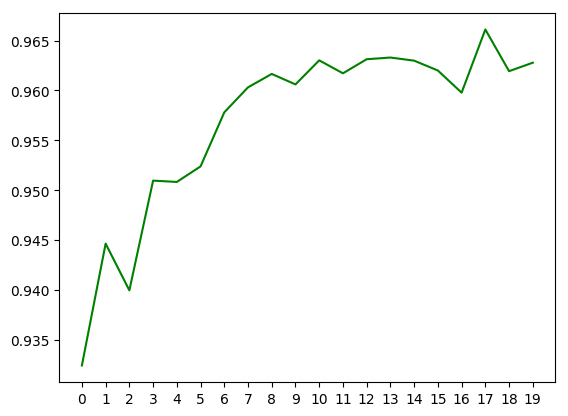

<Figure size 640x480 with 0 Axes>

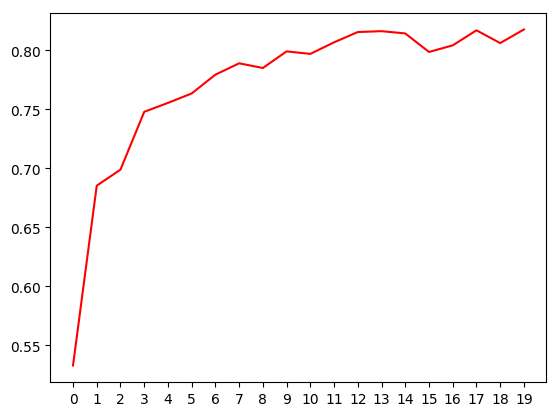

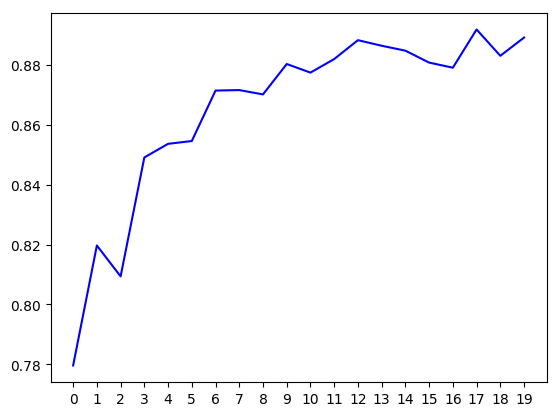

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

runner.save_train_data(PATH)

plt.figure()
accImage = runner.acc_bet
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(accImage,c="g")
plt.savefig(PATH + "acc.svg", dpi=300,format="svg")
plt.show()
plt.figure()
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
accImage = runner.f1_ma_bet
plt.plot(accImage,c="r")
plt.savefig(PATH + "f1_ma_bet.svg", dpi=300,format="svg")
plt.show()
accImage = runner.f1_mi_bet
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(accImage,c="b")
plt.savefig(PATH + "f1_mi_bet.svg", dpi=300,format="svg")
plt.show()

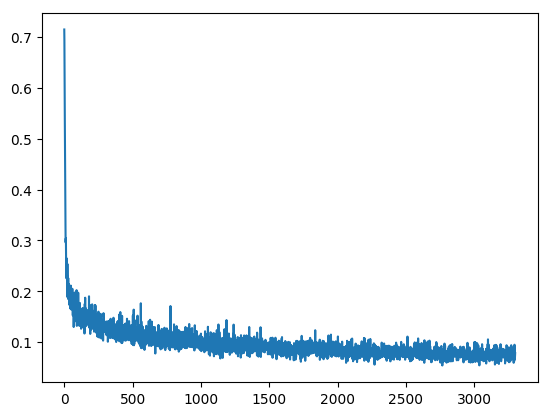

In [15]:
lossImage = runner.bestloss
plt.plot(lossImage)
plt.savefig("loss.svg", dpi=300,format="svg")
plt.show()

In [16]:
'''cqcc
epoch 0 now starting.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."
batch_id: 50, loss is: 0.2022
batch_id: 100, loss is: 0.1642
batch_id: 150, loss is: 0.1725
batch_id: 200, loss is: 0.1743
batch_id: 250, loss is: 0.1615
batch_id: 300, loss is: 0.1770
Piano :  0.8825380493445487
Harpsichord :  0.0
Violin :  0.8351441450122881
Cello :  0.6959627934916082
Viola :  0.7211629686788443
String Bass :  0.0
Bassoon :  0.6732092707465358
Clarinet :  0.5521043588503177
Flute :  0.49497314006182297
Horn :  0.49813466514230703
Oboe :  0.5976245509760955
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9345/0.1626/0.7796/0.5410
This model is better than the best saved one, and now replacing ...


 epoch 1 now starting.
batch_id: 50, loss is: 0.1598
batch_id: 100, loss is: 0.1426
batch_id: 150, loss is: 0.1441
batch_id: 200, loss is: 0.1169
batch_id: 250, loss is: 0.1391
batch_id: 300, loss is: 0.1511
Piano :  0.897986432851358
Harpsichord :  0.3677889770533991
Violin :  0.8525564069302436
Cello :  0.7262102060614499
Viola :  0.7405958735024469
String Bass :  0.006079921549399361
Bassoon :  0.6551002253272039
Clarinet :  0.5255761819427243
Flute :  0.46481038432171035
Horn :  0.5162860727728984
Oboe :  0.5886933053094174
best threshold: 0.28
[result] accuracy/loss/f1_micro/f1_macro: 0.9393/0.1501/0.7906/0.5765
This model is better than the best saved one, and now replacing ...


 epoch 2 now starting.
batch_id: 50, loss is: 0.1560
batch_id: 100, loss is: 0.1431
batch_id: 150, loss is: 0.1295
batch_id: 200, loss is: 0.1267
batch_id: 250, loss is: 0.1229
batch_id: 300, loss is: 0.1443
Piano :  0.8946215087571974
Harpsichord :  0.42123341139734577
Violin :  0.861310646907197
Cello :  0.7458278714175404
Viola :  0.7533348387694198
String Bass :  0.002447141738449491
Bassoon :  0.657429705979942
Clarinet :  0.5512308703817387
Flute :  0.5089787183191926
Horn :  0.5343407419283724
Oboe :  0.6103539997372915
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9409/0.1456/0.8000/0.5946
This model is better than the best saved one, and now replacing ...


 epoch 3 now starting.
batch_id: 50, loss is: 0.1344
batch_id: 100, loss is: 0.1612
batch_id: 150, loss is: 0.1354
batch_id: 200, loss is: 0.1135
batch_id: 250, loss is: 0.1106
batch_id: 300, loss is: 0.1302
Piano :  0.9126317237584263
Harpsichord :  0.7690595061395223
Violin :  0.8690194158871758
Cello :  0.7740203318259563
Viola :  0.7655780133936113
String Bass :  0.18584745762711863
Bassoon :  0.6543608291889476
Clarinet :  0.5302568404184063
Flute :  0.5140373768835761
Horn :  0.5519681974213487
Oboe :  0.635436504992044
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9435/0.1381/0.8143/0.6511
This model is better than the best saved one, and now replacing ...


 epoch 4 now starting.
batch_id: 50, loss is: 0.1344
batch_id: 100, loss is: 0.1151
batch_id: 150, loss is: 0.1079
batch_id: 200, loss is: 0.1236
batch_id: 250, loss is: 0.1024
batch_id: 300, loss is: 0.1593
Piano :  0.9243564883832474
Harpsichord :  0.7753895424031534
Violin :  0.8718115082684229
Cello :  0.7857275061771349
Viola :  0.7774853274518532
String Bass :  0.29790300497225625
Bassoon :  0.7575416658982067
Clarinet :  0.65060521221889
Flute :  0.5601239504653839
Horn :  0.6073963107313791
Oboe :  0.7039611813558531
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9491/0.1231/0.8380/0.7011
This model is better than the best saved one, and now replacing ...


 epoch 5 now starting.
batch_id: 50, loss is: 0.1314
batch_id: 100, loss is: 0.1319
batch_id: 150, loss is: 0.1103
batch_id: 200, loss is: 0.1324
batch_id: 250, loss is: 0.1139
batch_id: 300, loss is: 0.1226
Piano :  0.9213076386754985
Harpsichord :  0.8085167088697885
Violin :  0.8770702014794296
Cello :  0.7988101725430454
Viola :  0.7943378225103084
String Bass :  0.3528120713305899
Bassoon :  0.7032734033935533
Clarinet :  0.5780436800795207
Flute :  0.5355281501340482
Horn :  0.5941758272033502
Oboe :  0.6668674094148349
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9493/0.1258/0.8324/0.6937


 epoch 6 now starting.
batch_id: 50, loss is: 0.1290
batch_id: 100, loss is: 0.1078
batch_id: 150, loss is: 0.1056
batch_id: 200, loss is: 0.1097
batch_id: 250, loss is: 0.1299
batch_id: 300, loss is: 0.1042
Piano :  0.927463513722373
Harpsichord :  0.8255848386141545
Violin :  0.8795204030336511
Cello :  0.8033954126641835
Viola :  0.7965229867142534
String Bass :  0.37265839110108007
Bassoon :  0.7541131527139777
Clarinet :  0.6601785748281835
Flute :  0.5603492031265861
Horn :  0.6238839961719707
Oboe :  0.7086255069851285
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9522/0.1163/0.8452/0.7193
This model is better than the best saved one, and now replacing ...


 epoch 7 now starting.
batch_id: 50, loss is: 0.0856
batch_id: 100, loss is: 0.1027
batch_id: 150, loss is: 0.1159
batch_id: 200, loss is: 0.1234
batch_id: 250, loss is: 0.0993
batch_id: 300, loss is: 0.0917
Piano :  0.9277513852000333
Harpsichord :  0.8249727191561126
Violin :  0.8788432456286697
Cello :  0.8024409691706874
Viola :  0.7969435031378226
String Bass :  0.3761956731077872
Bassoon :  0.7610244083493877
Clarinet :  0.6688187887856716
Flute :  0.5630858621394039
Horn :  0.6305541269480558
Oboe :  0.7118698865728476
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9528/0.1160/0.8457/0.7220
This model is better than the best saved one, and now replacing ...


 epoch 8 now starting.
batch_id: 50, loss is: 0.1237
batch_id: 100, loss is: 0.1213
batch_id: 150, loss is: 0.1074
batch_id: 200, loss is: 0.1096
batch_id: 250, loss is: 0.1108
batch_id: 300, loss is: 0.1027
Piano :  0.9283395111316709
Harpsichord :  0.826855600539811
Violin :  0.8797709975334447
Cello :  0.8044070287992808
Viola :  0.798494864363431
String Bass :  0.37475702993391213
Bassoon :  0.7545586479717235
Clarinet :  0.6584060679675542
Flute :  0.5718843930635839
Horn :  0.6268162412462139
Oboe :  0.7098424058411045
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9530/0.1148/0.8461/0.7213


 epoch 9 now starting.
batch_id: 50, loss is: 0.1109
batch_id: 100, loss is: 0.1398
batch_id: 150, loss is: 0.1083
batch_id: 200, loss is: 0.1068
batch_id: 250, loss is: 0.0926
batch_id: 300, loss is: 0.1042
Piano :  0.9298926303986269
Harpsichord :  0.8276424355085935
Violin :  0.880279660427766
Cello :  0.8048620892559227
Viola :  0.7993581227090103
String Bass :  0.4143633215927407
Bassoon :  0.7639819595137927
Clarinet :  0.6676113673253807
Flute :  0.5654544838720603
Horn :  0.6326943128928344
Oboe :  0.7099932357862508
best threshold: 0.31
[result] accuracy/loss/f1_micro/f1_macro: 0.9531/0.1145/0.8474/0.7269
This model is better than the best saved one, and now replacing ...


 epoch 10 now starting.
batch_id: 50, loss is: 0.1088
batch_id: 100, loss is: 0.1025
batch_id: 150, loss is: 0.0907
batch_id: 200, loss is: 0.0973
batch_id: 250, loss is: 0.0993
batch_id: 300, loss is: 0.1061
Piano :  0.9306332217343988
Harpsichord :  0.8254205364681431
Violin :  0.8798159815167276
Cello :  0.8070753935541343
Viola :  0.8001493074925734
String Bass :  0.40828565309182147
Bassoon :  0.7618628400387358
Clarinet :  0.6715256574411503
Flute :  0.5775347448932002
Horn :  0.6349719783409756
Oboe :  0.7219191211707892
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9532/0.1137/0.8492/0.7290
This model is better than the best saved one, and now replacing ...


 epoch 11 now starting.
batch_id: 50, loss is: 0.1155
batch_id: 100, loss is: 0.0958
batch_id: 150, loss is: 0.1090
batch_id: 200, loss is: 0.0988
batch_id: 250, loss is: 0.1128
batch_id: 300, loss is: 0.1019
Piano :  0.929755582427581
Harpsichord :  0.8258309077370879
Violin :  0.8802911324877081
Cello :  0.8062844949127801
Viola :  0.8002321204769752
String Bass :  0.40563925697343745
Bassoon :  0.7657285788939058
Clarinet :  0.6725177582492937
Flute :  0.5644372678101606
Horn :  0.6387795806156003
Oboe :  0.7206357363089121
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9533/0.1138/0.8485/0.7282


 epoch 12 now starting.
batch_id: 50, loss is: 0.1001
batch_id: 100, loss is: 0.1193
batch_id: 150, loss is: 0.1067
batch_id: 200, loss is: 0.1004
batch_id: 250, loss is: 0.1067
batch_id: 300, loss is: 0.1008
Piano :  0.9302160858062875
Harpsichord :  0.8337310017976794
Violin :  0.8803783897470838
Cello :  0.8067963104629462
Viola :  0.801059327668649
String Bass :  0.40843406343724437
Bassoon :  0.7694444116152365
Clarinet :  0.679877687076392
Flute :  0.5651254086954554
Horn :  0.6385208633434701
Oboe :  0.7204226331155289
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9534/0.1132/0.8494/0.7304
This model is better than the best saved one, and now replacing ...


 epoch 13 now starting.
batch_id: 50, loss is: 0.1065
batch_id: 100, loss is: 0.1363
batch_id: 150, loss is: 0.1046
batch_id: 200, loss is: 0.1013
batch_id: 250, loss is: 0.0940
batch_id: 300, loss is: 0.1221
Piano :  0.930329144323906
Harpsichord :  0.8340539832285115
Violin :  0.8802014086537334
Cello :  0.8071963050981507
Viola :  0.8015439404534415
String Bass :  0.4375054922522628
Bassoon :  0.7679304262787491
Clarinet :  0.6786997891815038
Flute :  0.575210507825338
Horn :  0.635601248350933
Oboe :  0.7158975465472756
best threshold: 0.31
[result] accuracy/loss/f1_micro/f1_macro: 0.9539/0.1119/0.8491/0.7331
This model is better than the best saved one, and now replacing ...


 epoch 14 now starting.
batch_id: 50, loss is: 0.1121
batch_id: 100, loss is: 0.0980
batch_id: 150, loss is: 0.0942
batch_id: 200, loss is: 0.1209
batch_id: 250, loss is: 0.1124
batch_id: 300, loss is: 0.0944
Piano :  0.9306682014769136
Harpsichord :  0.8336648514690057
Violin :  0.8813915457605203
Cello :  0.8106217050120259
Viola :  0.8028695055508587
String Bass :  0.4057935809066893
Bassoon :  0.7640560612762788
Clarinet :  0.6750565010667252
Flute :  0.5803581718026136
Horn :  0.6334191246957119
Oboe :  0.719537795951151
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9537/0.1126/0.8500/0.7307


 epoch 15 now starting.
batch_id: 50, loss is: 0.1047
batch_id: 100, loss is: 0.1041
batch_id: 150, loss is: 0.1154
batch_id: 200, loss is: 0.1174
batch_id: 250, loss is: 0.1179
batch_id: 300, loss is: 0.0944
Piano :  0.9312330344657398
Harpsichord :  0.8407030406179425
Violin :  0.8814853613408793
Cello :  0.8110695737955113
Viola :  0.804101710884031
String Bass :  0.43763625932300626
Bassoon :  0.7626097693257482
Clarinet :  0.6726036459864745
Flute :  0.5654639232680161
Horn :  0.6327586713266175
Oboe :  0.7171973258027553
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9540/0.1124/0.8503/0.7324


 epoch 16 now starting.
batch_id: 50, loss is: 0.1229
batch_id: 100, loss is: 0.0998
batch_id: 150, loss is: 0.0982
batch_id: 200, loss is: 0.1106
batch_id: 250, loss is: 0.1054
batch_id: 300, loss is: 0.0953
Piano :  0.9310721364462173
Harpsichord :  0.8376373811610816
Violin :  0.881701612859768
Cello :  0.81200362704021
Viola :  0.8043083332530918
String Bass :  0.4526141992294992
Bassoon :  0.7703250619772479
Clarinet :  0.6833697712789534
Flute :  0.5655844511360526
Horn :  0.6381146638543466
Oboe :  0.7205841258394555
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9541/0.1120/0.8510/0.7361
This model is better than the best saved one, and now replacing ...


 epoch 17 now starting.
batch_id: 50, loss is: 0.0888
batch_id: 100, loss is: 0.1214
batch_id: 150, loss is: 0.1168
batch_id: 200, loss is: 0.0968
batch_id: 250, loss is: 0.1048
batch_id: 300, loss is: 0.1018
Piano :  0.931130432456398
Harpsichord :  0.839167935058346
Violin :  0.8822762548060532
Cello :  0.8122285744231342
Viola :  0.8048220014008334
String Bass :  0.4231493943472409
Bassoon :  0.772942223054593
Clarinet :  0.6861823077126127
Flute :  0.5759252150744012
Horn :  0.6379568246503425
Oboe :  0.7189116932953832
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9547/0.1109/0.8517/0.7350


 epoch 18 now starting.
batch_id: 50, loss is: 0.1065
batch_id: 100, loss is: 0.1075
batch_id: 150, loss is: 0.1036
batch_id: 200, loss is: 0.1181
batch_id: 250, loss is: 0.1111
batch_id: 300, loss is: 0.1162
Piano :  0.9328801486625385
Harpsichord :  0.8434421980300674
Violin :  0.8822225771000062
Cello :  0.813827201810373
Viola :  0.8069603674260541
String Bass :  0.43812438644106944
Bassoon :  0.779466017121506
Clarinet :  0.6869856044054709
Flute :  0.5850322670992285
Horn :  0.6460542300116764
Oboe :  0.7287358490566037
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9547/0.1102/0.8542/0.7403
This model is better than the best saved one, and now replacing ...


 epoch 19 now starting.
batch_id: 50, loss is: 0.1063
batch_id: 100, loss is: 0.0928
batch_id: 150, loss is: 0.0876
batch_id: 200, loss is: 0.1035
batch_id: 250, loss is: 0.0947
batch_id: 300, loss is: 0.1089
Piano :  0.9327433053183563
Harpsichord :  0.8440054723213988
Violin :  0.8824517653588986
Cello :  0.8145274965940122
Viola :  0.8076774415844206
String Bass :  0.454316800904338
Bassoon :  0.7729526167516068
Clarinet :  0.6806103695459571
Flute :  0.5842892304834439
Horn :  0.6402466380609463
Oboe :  0.7260367992027152
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9549/0.1102/0.8534/0.7400


 epoch 20 now starting.
batch_id: 50, loss is: 0.1099
batch_id: 100, loss is: 0.1053
batch_id: 150, loss is: 0.0979
batch_id: 200, loss is: 0.1151
batch_id: 250, loss is: 0.1038
batch_id: 300, loss is: 0.1139
Piano :  0.9311736270827636
Harpsichord :  0.8489576417474438
Violin :  0.8830216811435606
Cello :  0.8153234347274141
Viola :  0.8079711507796976
String Bass :  0.444374264304786
Bassoon :  0.7684933900180536
Clarinet :  0.6837224582440474
Flute :  0.5778902991737966
Horn :  0.642959452529575
Oboe :  0.7264120234740474
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9547/0.1106/0.8533/0.7391


 epoch 21 now starting.
batch_id: 50, loss is: 0.0990
batch_id: 100, loss is: 0.0919
batch_id: 150, loss is: 0.1121
batch_id: 200, loss is: 0.0959
batch_id: 250, loss is: 0.1170
batch_id: 300, loss is: 0.0877
Piano :  0.9323864398961057
Harpsichord :  0.8466602706189831
Violin :  0.8837310911904418
Cello :  0.8153113827425301
Viola :  0.8089359483030013
String Bass :  0.4604071132982888
Bassoon :  0.7811144654532186
Clarinet :  0.6907274997162638
Flute :  0.5928985456943529
Horn :  0.6497913736244253
Oboe :  0.7337185072930479
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9553/0.1086/0.8551/0.7451
This model is better than the best saved one, and now replacing ...

'''

'cqcc\nepoch 0 now starting.\n/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.\n  "When training, we now always track global mean and variance."\nbatch_id: 50, loss is: 0.2022\nbatch_id: 100, loss is: 0.1642\nbatch_id: 150, loss is: 0.1725\nbatch_id: 200, loss is: 0.1743\nbatch_id: 250, loss is: 0.1615\nbatch_id: 300, loss is: 0.1770\nPiano :  0.8825380493445487\nHarpsichord :  0.0\nViolin :  0.8351441450122881\nCello :  0.6959627934916082\nViola :  0.7211629686788443\nString Bass :  0.0\nBassoon :  0.6732092707465358\nClarinet :  0.5521043588503177\nFlute :  0.49497314006182297\nHorn :  0.49813466514230703\nOboe :  0.5976245509760955\nbest threshold: 0.36\n[result] accuracy/loss/f1_micro/f1_macro: 0.9345/0.1626/0.7796/0.5410\nThis model is better than the best saved one, and now replacing ...\n\n\n epoch 1 now starting.\nbatch_id: 50, loss is: 0.1598\nbatch_id: 100,

In [17]:
'''1+2
epoch 19 now starting.
batch_id: 50, loss is: 0.2527
batch_id: 100, loss is: 0.2508
batch_id: 150, loss is: 0.2556
batch_id: 200, loss is: 0.2272
batch_id: 250, loss is: 0.2117
batch_id: 300, loss is: 0.2182
Piano :  0.8738638806671828
Violin :  0.8184627765396126
Cello :  0.6761719552474409
Viola :  0.6829305531320886
Bassoon :  0.6485970108757094
Clarinet :  0.5393773506882225
Horn :  0.47040855288277966
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.8922/0.2483/0.7777/0.6728
This model is better than the best saved one, and now replacing ...
'''

'1+2\nepoch 19 now starting.\nbatch_id: 50, loss is: 0.2527\nbatch_id: 100, loss is: 0.2508\nbatch_id: 150, loss is: 0.2556\nbatch_id: 200, loss is: 0.2272\nbatch_id: 250, loss is: 0.2117\nbatch_id: 300, loss is: 0.2182\nPiano :  0.8738638806671828\nViolin :  0.8184627765396126\nCello :  0.6761719552474409\nViola :  0.6829305531320886\nBassoon :  0.6485970108757094\nClarinet :  0.5393773506882225\nHorn :  0.47040855288277966\nbest threshold: 0.35000000000000003\n[result] accuracy/loss/f1_micro/f1_macro: 0.8922/0.2483/0.7777/0.6728\nThis model is better than the best saved one, and now replacing ...\n'

In [18]:
'''1od
epoch 0 now starting.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."
batch_id: 50, loss is: 0.2009
batch_id: 100, loss is: 0.1596
batch_id: 150, loss is: 0.1623
batch_id: 200, loss is: 0.1547
batch_id: 250, loss is: 0.1454
batch_id: 300, loss is: 0.1463
Piano :  0.8757459236279306
Harpsichord :  0.5480099829239459
Violin :  0.8095947337230256
Cello :  0.667156046914113
Viola :  0.6755548169934804
String Bass :  0.017379742627855074
Bassoon :  0.6076096034914764
Clarinet :  0.49894369664873855
Flute :  0.3846358024162821
Horn :  0.4936579591742002
Oboe :  0.5611689497716895
best threshold: 0.16
[result] accuracy/loss/f1_micro/f1_macro: 0.9378/0.1531/0.7474/0.5581
This model is better than the best saved one, and now replacing ...


 epoch 1 now starting.
batch_id: 50, loss is: 0.1386
batch_id: 100, loss is: 0.1552
batch_id: 150, loss is: 0.1322
batch_id: 200, loss is: 0.1381
batch_id: 250, loss is: 0.1573
batch_id: 300, loss is: 0.1373
Piano :  0.9034814854469526
Harpsichord :  0.7506678539626002
Violin :  0.8555519489980057
Cello :  0.7503226845091666
Viola :  0.7507877454427582
String Bass :  0.024625623960066553
Bassoon :  0.726499062585983
Clarinet :  0.6133623686523502
Flute :  0.5218260579806732
Horn :  0.5405829801506236
Oboe :  0.6445164564869401
best threshold: 0.27
[result] accuracy/loss/f1_micro/f1_macro: 0.9427/0.1400/0.8128/0.6438
This model is better than the best saved one, and now replacing ...


 epoch 2 now starting.
batch_id: 50, loss is: 0.1259
batch_id: 100, loss is: 0.1046
batch_id: 150, loss is: 0.1560
batch_id: 200, loss is: 0.1290
batch_id: 250, loss is: 0.1380
batch_id: 300, loss is: 0.1002
Piano :  0.9112753601615264
Harpsichord :  0.8201286173633441
Violin :  0.8588013028643401
Cello :  0.7605030503704463
Viola :  0.7569469801301275
String Bass :  0.17271086314407616
Bassoon :  0.7469631890514813
Clarinet :  0.624378836597486
Flute :  0.5590629748055423
Horn :  0.6049541398889374
Oboe :  0.6548547129695251
best threshold: 0.25
[result] accuracy/loss/f1_micro/f1_macro: 0.9481/0.1284/0.8190/0.6791
This model is better than the best saved one, and now replacing ...


 epoch 3 now starting.
batch_id: 50, loss is: 0.1478
batch_id: 100, loss is: 0.1385
batch_id: 150, loss is: 0.1353
batch_id: 200, loss is: 0.1043
batch_id: 250, loss is: 0.1351
batch_id: 300, loss is: 0.1241
Piano :  0.9151331269209103
Harpsichord :  0.8007232415448914
Violin :  0.8693507697131299
Cello :  0.7771198740043433
Viola :  0.77311324281154
String Bass :  0.33871773522064946
Bassoon :  0.7502029463403583
Clarinet :  0.6284631650434487
Flute :  0.5501142124909466
Horn :  0.5986319459485897
Oboe :  0.6857485907324121
best threshold: 0.29
[result] accuracy/loss/f1_micro/f1_macro: 0.9482/0.1271/0.8305/0.6988
This model is better than the best saved one, and now replacing ...


 epoch 4 now starting.
batch_id: 50, loss is: 0.1256
batch_id: 100, loss is: 0.0933
batch_id: 150, loss is: 0.1254
batch_id: 200, loss is: 0.1207
batch_id: 250, loss is: 0.1116
batch_id: 300, loss is: 0.1328
Piano :  0.9172725283033885
Harpsichord :  0.8413938215321837
Violin :  0.8576319431319298
Cello :  0.7638464602375384
Viola :  0.7658478163195807
String Bass :  0.38281372150473747
Bassoon :  0.7809103755948873
Clarinet :  0.667681342032927
Flute :  0.5930585327570252
Horn :  0.6257735446085682
Oboe :  0.6983858979417675
best threshold: 0.31
[result] accuracy/loss/f1_micro/f1_macro: 0.9503/0.1245/0.8261/0.7177
This model is better than the best saved one, and now replacing ...


 epoch 5 now starting.
batch_id: 50, loss is: 0.1133
batch_id: 100, loss is: 0.1152
batch_id: 150, loss is: 0.1112
batch_id: 200, loss is: 0.1025
batch_id: 250, loss is: 0.1050
batch_id: 300, loss is: 0.1202
Piano :  0.9214339210844632
Harpsichord :  0.809690235086776
Violin :  0.8730014850998028
Cello :  0.775145288630598
Viola :  0.780521758209827
String Bass :  0.367792785426955
Bassoon :  0.7794731601115777
Clarinet :  0.6780967750955728
Flute :  0.6192116245160642
Horn :  0.6382711666708928
Oboe :  0.7185172116364776
best threshold: 0.3
[result] accuracy/loss/f1_micro/f1_macro: 0.9519/0.1179/0.8366/0.7237
This model is better than the best saved one, and now replacing ...


 epoch 6 now starting.
batch_id: 50, loss is: 0.1060
batch_id: 100, loss is: 0.1293
batch_id: 150, loss is: 0.1031
batch_id: 200, loss is: 0.1145
batch_id: 250, loss is: 0.1022
batch_id: 300, loss is: 0.1399
Piano :  0.9253428828231283
Harpsichord :  0.8724145283957638
Violin :  0.8628947533829591
Cello :  0.7911374515614316
Viola :  0.7762833595005233
String Bass :  0.45619533896162984
Bassoon :  0.7870855257012983
Clarinet :  0.6876516523534109
Flute :  0.6325430470508192
Horn :  0.6497322413463731
Oboe :  0.7168375924680563
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9537/0.1171/0.8389/0.7416
This model is better than the best saved one, and now replacing ...


 epoch 7 now starting.
batch_id: 50, loss is: 0.1090
batch_id: 100, loss is: 0.1088
batch_id: 150, loss is: 0.1017
batch_id: 200, loss is: 0.1221
batch_id: 250, loss is: 0.1216
batch_id: 300, loss is: 0.0896
Piano :  0.9316490670962946
Harpsichord :  0.8825554835850407
Violin :  0.8839768619040731
Cello :  0.8028613796388548
Viola :  0.7990985722336885
String Bass :  0.49886321965529884
Bassoon :  0.8068254008588928
Clarinet :  0.7097904224392736
Flute :  0.642042876198072
Horn :  0.6638338241397711
Oboe :  0.7431352520579223
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9569/0.1062/0.8547/0.7604
This model is better than the best saved one, and now replacing ...


 epoch 8 now starting.
batch_id: 50, loss is: 0.0911
batch_id: 100, loss is: 0.0959
batch_id: 150, loss is: 0.0800
batch_id: 200, loss is: 0.1036
batch_id: 250, loss is: 0.1356
batch_id: 300, loss is: 0.1160
Piano :  0.9335788700855041
Harpsichord :  0.8897538396802018
Violin :  0.8851330687261342
Cello :  0.8079147868735844
Viola :  0.8010257843511235
String Bass :  0.4904632152588556
Bassoon :  0.7992972465392421
Clarinet :  0.7041601705491639
Flute :  0.64156131154281
Horn :  0.6623392992185531
Oboe :  0.755749208460294
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9576/0.1050/0.8558/0.7610
This model is better than the best saved one, and now replacing ...


 epoch 9 now starting.
batch_id: 50, loss is: 0.0984
batch_id: 100, loss is: 0.0868
batch_id: 150, loss is: 0.0954
batch_id: 200, loss is: 0.0957
batch_id: 250, loss is: 0.0883
batch_id: 300, loss is: 0.0820
Piano :  0.9366084744004101
Harpsichord :  0.8759206050397966
Violin :  0.8894225598992814
Cello :  0.8211359491069627
Viola :  0.8161543444477419
String Bass :  0.5148254007704736
Bassoon :  0.8077603624179602
Clarinet :  0.7142462821729579
Flute :  0.6486068730262369
Horn :  0.6758899881757998
Oboe :  0.7560811014977388
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9588/0.1014/0.8645/0.7688
This model is better than the best saved one, and now replacing ...


 epoch 10 now starting.
batch_id: 50, loss is: 0.0881
batch_id: 100, loss is: 0.0972
batch_id: 150, loss is: 0.0916
batch_id: 200, loss is: 0.1038
batch_id: 250, loss is: 0.1004
batch_id: 300, loss is: 0.1078
Piano :  0.9291646528608466
Harpsichord :  0.8664429105186499
Violin :  0.8822485454052826
Cello :  0.8146984660240982
Viola :  0.8121161578940564
String Bass :  0.5174314455008956
Bassoon :  0.7894090933344402
Clarinet :  0.707820181440373
Flute :  0.6533605229342421
Horn :  0.6411534516662203
Oboe :  0.7436920686609414
best threshold: 0.4
[result] accuracy/loss/f1_micro/f1_macro: 0.9569/0.1065/0.8567/0.7598


 epoch 11 now starting.
batch_id: 50, loss is: 0.0803
batch_id: 100, loss is: 0.0937
batch_id: 150, loss is: 0.1132
batch_id: 200, loss is: 0.0937
batch_id: 250, loss is: 0.1046
batch_id: 300, loss is: 0.1149
Piano :  0.9349674847214416
Harpsichord :  0.9028976778424681
Violin :  0.8918680681308527
Cello :  0.8283326011097543
Viola :  0.8202136368174103
String Bass :  0.5320097044115463
Bassoon :  0.8053645285235311
Clarinet :  0.7145651273988158
Flute :  0.6476239870340357
Horn :  0.6701205314794791
Oboe :  0.7554783759199537
best threshold: 0.39
[result] accuracy/loss/f1_micro/f1_macro: 0.9596/0.1004/0.8659/0.7730
This model is better than the best saved one, and now replacing ...


 epoch 12 now starting.
batch_id: 50, loss is: 0.0943
batch_id: 100, loss is: 0.0846
batch_id: 150, loss is: 0.0957
batch_id: 200, loss is: 0.0863
batch_id: 250, loss is: 0.0812
batch_id: 300, loss is: 0.0899
Piano :  0.9372551467888094
Harpsichord :  0.9022911948847743
Violin :  0.8906303336942849
Cello :  0.8289413012403745
Viola :  0.8175499307115959
String Bass :  0.5457511009623226
Bassoon :  0.8083437528590163
Clarinet :  0.7195008890982871
Flute :  0.6559064210050706
Horn :  0.6811777793496364
Oboe :  0.7560574611068865
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9600/0.0988/0.8665/0.7767
This model is better than the best saved one, and now replacing ...


 epoch 13 now starting.
batch_id: 50, loss is: 0.0843
batch_id: 100, loss is: 0.1088
batch_id: 150, loss is: 0.0726
batch_id: 200, loss is: 0.0947
batch_id: 250, loss is: 0.1005
batch_id: 300, loss is: 0.0815
Piano :  0.9377050329454647
Harpsichord :  0.9020965058236272
Violin :  0.8919306089672455
Cello :  0.830096145262022
Viola :  0.8203421268270373
String Bass :  0.5387139905190228
Bassoon :  0.8066605556938281
Clarinet :  0.7148607648172068
Flute :  0.6523211693702412
Horn :  0.675732162917679
Oboe :  0.7570424341936478
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9598/0.0989/0.8673/0.7752


 epoch 14 now starting.
batch_id: 50, loss is: 0.0925
batch_id: 100, loss is: 0.1106
batch_id: 150, loss is: 0.0990
batch_id: 200, loss is: 0.1030
batch_id: 250, loss is: 0.1102
batch_id: 300, loss is: 0.0915
Piano :  0.9370760933760219
Harpsichord :  0.903888113889187
Violin :  0.8928735395918599
Cello :  0.8348223166208556
Viola :  0.8228455439020108
String Bass :  0.5391219749483157
Bassoon :  0.8024995014292361
Clarinet :  0.7085366935841689
Flute :  0.646172795155372
Horn :  0.6741088155871675
Oboe :  0.7543094065820161
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9599/0.0988/0.8679/0.7742


 epoch 15 now starting.
batch_id: 50, loss is: 0.0973
batch_id: 100, loss is: 0.0790
batch_id: 150, loss is: 0.1054
batch_id: 200, loss is: 0.0869
batch_id: 250, loss is: 0.0845
batch_id: 300, loss is: 0.0984
Piano :  0.9361260808030585
Harpsichord :  0.9052040884494622
Violin :  0.8926795772788034
Cello :  0.8333111072256582
Viola :  0.823642802852661
String Bass :  0.5404584500023729
Bassoon :  0.8037574370986389
Clarinet :  0.7176513120236195
Flute :  0.6432776135714463
Horn :  0.6753471880232442
Oboe :  0.7586121488575615
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9596/0.0993/0.8679/0.7755


 epoch 16 now starting.
batch_id: 50, loss is: 0.0818
batch_id: 100, loss is: 0.0977
batch_id: 150, loss is: 0.1003
batch_id: 200, loss is: 0.1151
batch_id: 250, loss is: 0.0824
batch_id: 300, loss is: 0.0914
Piano :  0.9384684107828695
Harpsichord :  0.9089551225473556
Violin :  0.8932791770702688
Cello :  0.8332288308973962
Viola :  0.8236990730830331
String Bass :  0.5450214832804035
Bassoon :  0.8077681889153826
Clarinet :  0.7241264762370228
Flute :  0.6521542292311174
Horn :  0.6752593482975777
Oboe :  0.7581643498739137
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9603/0.0977/0.8695/0.7782
This model is better than the best saved one, and now replacing ...


 epoch 17 now starting.
batch_id: 50, loss is: 0.0863
batch_id: 100, loss is: 0.0873
batch_id: 150, loss is: 0.1202
batch_id: 200, loss is: 0.0920
batch_id: 250, loss is: 0.0841
batch_id: 300, loss is: 0.1030
Piano :  0.937396684696334
Harpsichord :  0.9066001639792293
Violin :  0.8925664301283978
Cello :  0.8329496094815475
Viola :  0.8228347430676425
String Bass :  0.5360141405214316
Bassoon :  0.8049976603851554
Clarinet :  0.7185038556742078
Flute :  0.6554029292457003
Horn :  0.6752113514843153
Oboe :  0.7557087728325186
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9602/0.0986/0.8682/0.7762


 epoch 18 now starting.
batch_id: 50, loss is: 0.0984
batch_id: 100, loss is: 0.0922
batch_id: 150, loss is: 0.1023
batch_id: 200, loss is: 0.0958
batch_id: 250, loss is: 0.0861
batch_id: 300, loss is: 0.0803
Piano :  0.9385140868859951
Harpsichord :  0.9086188637994057
Violin :  0.892340383627276
Cello :  0.8358135247574816
Viola :  0.8248216416942207
String Bass :  0.5307749933544381
Bassoon :  0.8067818922015553
Clarinet :  0.7223834514489821
Flute :  0.6517029786599756
Horn :  0.6809408031781451
Oboe :  0.7606705141015969
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9609/0.0974/0.8700/0.7776


 epoch 19 now starting.
batch_id: 50, loss is: 0.0938
batch_id: 100, loss is: 0.1002
batch_id: 150, loss is: 0.1005
batch_id: 200, loss is: 0.0753
batch_id: 250, loss is: 0.0954
batch_id: 300, loss is: 0.0961
Piano :  0.9384560440739953
Harpsichord :  0.9100784550392275
Violin :  0.8935359768925419
Cello :  0.8369065940570617
Viola :  0.8243485462069587
String Bass :  0.5382684451444603
Bassoon :  0.8068281541143235
Clarinet :  0.7193027352804822
Flute :  0.6505491808308277
Horn :  0.67981147911421
Oboe :  0.7582117422699868
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9603/0.0977/0.8697/0.7778


 epoch 20 now starting.
batch_id: 50, loss is: 0.0997
batch_id: 100, loss is: 0.0822
batch_id: 150, loss is: 0.0904
batch_id: 200, loss is: 0.0866
batch_id: 250, loss is: 0.1097
batch_id: 300, loss is: 0.1003
Piano :  0.9394051082034978
Harpsichord :  0.9030461732241704
Violin :  0.8937317158688322
Cello :  0.8357692383369733
Viola :  0.8247449140189541
String Bass :  0.5439737889070911
Bassoon :  0.8135849332512811
Clarinet :  0.7316788276294
Flute :  0.6585289827063826
Horn :  0.6847984395318596
Oboe :  0.7632914500879958
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9607/0.0966/0.8712/0.7811
This model is better than the best saved one, and now replacing ...


 epoch 21 now starting.
batch_id: 50, loss is: 0.0930
batch_id: 100, loss is: 0.1031
batch_id: 150, loss is: 0.0855
batch_id: 200, loss is: 0.0896
batch_id: 250, loss is: 0.0925
batch_id: 300, loss is: 0.0868
Piano :  0.9369411618931179
Harpsichord :  0.9089096658875291
Violin :  0.8937107462138001
Cello :  0.8311252806640682
Viola :  0.8224623148501782
String Bass :  0.5365527488855869
Bassoon :  0.8089958744569252
Clarinet :  0.7287196117665998
Flute :  0.6639426944341585
Horn :  0.6776924903062435
Oboe :  0.7607724455973484
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9601/0.0977/0.8688/0.7791
'''

'1od\nepoch 0 now starting.\n/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.\n  "When training, we now always track global mean and variance."\nbatch_id: 50, loss is: 0.2009\nbatch_id: 100, loss is: 0.1596\nbatch_id: 150, loss is: 0.1623\nbatch_id: 200, loss is: 0.1547\nbatch_id: 250, loss is: 0.1454\nbatch_id: 300, loss is: 0.1463\nPiano :  0.8757459236279306\nHarpsichord :  0.5480099829239459\nViolin :  0.8095947337230256\nCello :  0.667156046914113\nViola :  0.6755548169934804\nString Bass :  0.017379742627855074\nBassoon :  0.6076096034914764\nClarinet :  0.49894369664873855\nFlute :  0.3846358024162821\nHorn :  0.4936579591742002\nOboe :  0.5611689497716895\nbest threshold: 0.16\n[result] accuracy/loss/f1_micro/f1_macro: 0.9378/0.1531/0.7474/0.5581\nThis model is better than the best saved one, and now replacing ...\n\n\n epoch 1 now starting.\nbatch_id: 50, lo

In [19]:
'''
cqt only
 epoch 66 now starting.
batch_id: 50, loss is: 0.0886
batch_id: 100, loss is: 0.0977
batch_id: 150, loss is: 0.0834
batch_id: 200, loss is: 0.0986
batch_id: 250, loss is: 0.1098
batch_id: 300, loss is: 0.1092
Piano :  0.928056451093857
Harpsichord :  0.8633907898121945
Violin :  0.8786083093677223
Cello :  0.8216107273399148
Viola :  0.8076489659840159
String Bass :  0.4919690831250179
Bassoon :  0.7618073643826948
Clarinet :  0.6585693892643998
Flute :  0.6399751410268668
Horn :  0.645877081084617
Oboe :  0.6977240536292905
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9543/0.1091/0.8525/0.7450
This model is better than the best saved one, and now replacing ...


 epoch 67 now starting.
batch_id: 50, loss is: 0.1016
batch_id: 100, loss is: 0.0803
batch_id: 150, loss is: 0.0966
batch_id: 200, loss is: 0.0818
batch_id: 250, loss is: 0.1130
batch_id: 300, loss is: 0.1313
Piano :  0.9281225414902783
Harpsichord :  0.8659976387249115
Violin :  0.8762653629520195
Cello :  0.8193759075614456
Viola :  0.8075826622911038
String Bass :  0.48485920684063094
Bassoon :  0.7324680671267455
Clarinet :  0.6485949994837619
Flute :  0.6272619960327601
Horn :  0.6345886582209677
Oboe :  0.6769810973646692
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9535/0.1116/0.8490/0.7366


 epoch 68 now starting.
batch_id: 50, loss is: 0.1183
batch_id: 100, loss is: 0.1021
batch_id: 150, loss is: 0.0928
batch_id: 200, loss is: 0.0979
batch_id: 250, loss is: 0.0766
batch_id: 300, loss is: 0.1010
Piano :  0.9272354065403926
Harpsichord :  0.8654457294499232
Violin :  0.8759363643749943
Cello :  0.8179063731218266
Viola :  0.8042597496661462
String Bass :  0.48493841816293215
Bassoon :  0.7468179224550442
Clarinet :  0.6462663234960003
Flute :  0.6268613837682547
Horn :  0.6372482935991153
Oboe :  0.689523667090406
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9536/0.1118/0.8490/0.7384


 epoch 69 now starting.
batch_id: 50, loss is: 0.1006
batch_id: 100, loss is: 0.0955
batch_id: 150, loss is: 0.0881
batch_id: 200, loss is: 0.0983
batch_id: 250, loss is: 0.0789
batch_id: 300, loss is: 0.0941
Piano :  0.9232019233520382
Harpsichord :  0.8702500757295277
Violin :  0.8706568034073077
Cello :  0.8092141023784488
Viola :  0.7987916196158182
String Bass :  0.4702774108322325
Bassoon :  0.7184327923967156
Clarinet :  0.6320397468362833
Flute :  0.6159060646410845
Horn :  0.6241005358509824
Oboe :  0.6621674050147519
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9516/0.1152/0.8416/0.7268


 epoch 70 now starting.
batch_id: 50, loss is: 0.0800
batch_id: 100, loss is: 0.0750
batch_id: 150, loss is: 0.0906
batch_id: 200, loss is: 0.1183
batch_id: 250, loss is: 0.1255
batch_id: 300, loss is: 0.0900
Piano :  0.9242435094706436
Harpsichord :  0.8599269999665137
Violin :  0.8732267783851525
Cello :  0.8124721207096941
Viola :  0.8015976294595311
String Bass :  0.4991794546972621
Bassoon :  0.7257393528335788
Clarinet :  0.6229676139054351
Flute :  0.6296583564173592
Horn :  0.6285828204682988
Oboe :  0.6707813964712324
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9521/0.1144/0.8433/0.7317


 epoch 71 now starting.
batch_id: 50, loss is: 0.0896
batch_id: 100, loss is: 0.1025
batch_id: 150, loss is: 0.0852
batch_id: 200, loss is: 0.0961
batch_id: 250, loss is: 0.0815
batch_id: 300, loss is: 0.0995
Piano :  0.9259503327995313
Harpsichord :  0.8659989814971991
Violin :  0.8789419337097525
Cello :  0.8217233950706948
Viola :  0.8071857968234661
String Bass :  0.47648194919031345
Bassoon :  0.7568321937002578
Clarinet :  0.6426841530346709
Flute :  0.6275105445793268
Horn :  0.6435176089587995
Oboe :  0.6984402734242229
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9539/0.1110/0.8499/0.7405


 epoch 72 now starting.
batch_id: 50, loss is: 0.0916
batch_id: 100, loss is: 0.0949
batch_id: 150, loss is: 0.0910
batch_id: 200, loss is: 0.1005
batch_id: 250, loss is: 0.0966
batch_id: 300, loss is: 0.0940
Piano :  0.9234950742723392
Harpsichord :  0.8686950642325895
Violin :  0.8775521682884302
Cello :  0.8196119674070097
Viola :  0.805694369137164
String Bass :  0.4819531044173179
Bassoon :  0.7347061230055911
Clarinet :  0.6213622920100241
Flute :  0.6168175754642364
Horn :  0.6294797981078957
Oboe :  0.679655245994415
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9524/0.1129/0.8457/0.7326


 epoch 73 now starting.
batch_id: 50, loss is: 0.1052
batch_id: 100, loss is: 0.1002
batch_id: 150, loss is: 0.1099
batch_id: 200, loss is: 0.0957
batch_id: 250, loss is: 0.1029
batch_id: 300, loss is: 0.0821
Piano :  0.9283657780552569
Harpsichord :  0.8689973614775726
Violin :  0.876350276833917
Cello :  0.8193976880853234
Viola :  0.8089509578682682
String Bass :  0.48260973854641404
Bassoon :  0.7361971231036405
Clarinet :  0.631957262703505
Flute :  0.6310942843185148
Horn :  0.6384204238194051
Oboe :  0.6844808906489334
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9536/0.1112/0.8489/0.7370


 epoch 74 now starting.
batch_id: 50, loss is: 0.0910
batch_id: 100, loss is: 0.0839
batch_id: 150, loss is: 0.0809
batch_id: 200, loss is: 0.1091
batch_id: 250, loss is: 0.1048
batch_id: 300, loss is: 0.0997
Piano :  0.9249276208530212
Harpsichord :  0.8689339437540875
Violin :  0.8743315321596653
Cello :  0.8150275501591147
Viola :  0.8022833621000305
String Bass :  0.4966739321199083
Bassoon :  0.7340728177172801
Clarinet :  0.6343079218798683
Flute :  0.6218090945185325
Horn :  0.6373671942247159
Oboe :  0.6733533016405154
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9522/0.1135/0.8453/0.7348


 epoch 75 now starting.
batch_id: 50, loss is: 0.0931
batch_id: 100, loss is: 0.0943
batch_id: 150, loss is: 0.1143
batch_id: 200, loss is: 0.0890
batch_id: 250, loss is: 0.0921
batch_id: 300, loss is: 0.0877
Piano :  0.9274492568417511
Harpsichord :  0.8652665589660743
Violin :  0.8765714721893572
Cello :  0.8195124578455012
Viola :  0.8060718900208315
String Bass :  0.5068838471979833
Bassoon :  0.7438886799548704
Clarinet :  0.6448932206947214
Flute :  0.639050416641688
Horn :  0.6397656684005858
Oboe :  0.6874206669075613
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9536/0.1110/0.8491/0.7415


 epoch 76 now starting.
batch_id: 50, loss is: 0.0824
batch_id: 100, loss is: 0.0806
batch_id: 150, loss is: 0.1030
batch_id: 200, loss is: 0.0919
batch_id: 250, loss is: 0.0887
batch_id: 300, loss is: 0.0888
Piano :  0.9250115737386192
Harpsichord :  0.8702844066688461
Violin :  0.8761503766143117
Cello :  0.8179963728143379
Viola :  0.8010999245080677
String Bass :  0.48435279445459556
Bassoon :  0.7276981324711788
Clarinet :  0.6217324062315324
Flute :  0.6239764555099327
Horn :  0.6250573380652327
Oboe :  0.6733665604488384
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9522/0.1141/0.8442/0.7315


 epoch 77 now starting.
batch_id: 50, loss is: 0.0899
batch_id: 100, loss is: 0.1372
batch_id: 150, loss is: 0.0943
batch_id: 200, loss is: 0.0894
batch_id: 250, loss is: 0.0968
batch_id: 300, loss is: 0.0947
Piano :  0.9257204208582742
Harpsichord :  0.872931833223031
Violin :  0.8800496317731877
Cello :  0.8253206578525181
Viola :  0.809885859105547
String Bass :  0.4971418869205954
Bassoon :  0.7533390008725027
Clarinet :  0.6200380859562845
Flute :  0.6262783721864004
Horn :  0.6415281153158713
Oboe :  0.691220988900101
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9538/0.1108/0.8495/0.7403


 epoch 78 now starting.
batch_id: 50, loss is: 0.0762
batch_id: 100, loss is: 0.0779
batch_id: 150, loss is: 0.0852
batch_id: 200, loss is: 0.0934
batch_id: 250, loss is: 0.0854
batch_id: 300, loss is: 0.0986
Piano :  0.9192903243194397
Harpsichord :  0.8680349998373614
Violin :  0.8766995390091615
Cello :  0.8189755371215437
Viola :  0.8026186278863037
String Bass :  0.48616917192920045
Bassoon :  0.7342703824392459
Clarinet :  0.6123289216423522
Flute :  0.6161218747855525
Horn :  0.6321878405433489
Oboe :  0.6820019899407583
best threshold: 0.39
[result] accuracy/loss/f1_micro/f1_macro: 0.9520/0.1152/0.8425/0.7317


 epoch 79 now starting.
batch_id: 50, loss is: 0.0873
batch_id: 100, loss is: 0.0955
batch_id: 150, loss is: 0.0754
batch_id: 200, loss is: 0.1005
batch_id: 250, loss is: 0.0833
batch_id: 300, loss is: 0.0929
Piano :  0.9275395542477882
Harpsichord :  0.8757552745402317
Violin :  0.8737882742350378
Cello :  0.815064942138079
Viola :  0.8025317704424785
String Bass :  0.4853841709994223
Bassoon :  0.7303448538907081
Clarinet :  0.6398817477835957
Flute :  0.6195400020983177
Horn :  0.6375422489027897
Oboe :  0.6671883631007182
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9523/0.1127/0.8462/0.7341


 epoch 80 now starting.
batch_id: 50, loss is: 0.0694
batch_id: 100, loss is: 0.1044
batch_id: 150, loss is: 0.1045
batch_id: 200, loss is: 0.0969
batch_id: 250, loss is: 0.1062
batch_id: 300, loss is: 0.0941
Piano :  0.9244022272916665
Harpsichord :  0.8795120152830379
Violin :  0.873148048166248
Cello :  0.8101701821515659
Viola :  0.7999165501475909
String Bass :  0.49018772542671324
Bassoon :  0.7090306999504329
Clarinet :  0.6063111350568039
Flute :  0.6287588199081309
Horn :  0.6294420574702135
Oboe :  0.6599932375918709
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9506/0.1157/0.8407/0.7283


 epoch 81 now starting.
batch_id: 50, loss is: 0.1016
batch_id: 100, loss is: 0.0807
batch_id: 150, loss is: 0.0919
batch_id: 200, loss is: 0.0961
batch_id: 250, loss is: 0.1187
batch_id: 300, loss is: 0.0850
Piano :  0.9304979556615944
Harpsichord :  0.8707104801614878
Violin :  0.8798596816945075
Cello :  0.8249323263661421
Viola :  0.810469441953448
String Bass :  0.4978977776506593
Bassoon :  0.7491573266915733
Clarinet :  0.6459898070887365
Flute :  0.6372852213160753
Horn :  0.6391357684700698
Oboe :  0.6915290647927324
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9547/0.1085/0.8527/0.7434


 epoch 82 now starting.
batch_id: 50, loss is: 0.0881
batch_id: 100, loss is: 0.1173
batch_id: 150, loss is: 0.0931
batch_id: 200, loss is: 0.0867
batch_id: 250, loss is: 0.0972
batch_id: 300, loss is: 0.0951
Piano :  0.9252849320036832
Harpsichord :  0.86775956284153
Violin :  0.8799162508712342
Cello :  0.8194816857229587
Viola :  0.8030972100149497
String Bass :  0.5184889385831802
Bassoon :  0.744143235958011
Clarinet :  0.6137745166767927
Flute :  0.6346894458374824
Horn :  0.6399158172321112
Oboe :  0.6944433894185119
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9532/0.1115/0.8470/0.7401


 epoch 83 now starting.
batch_id: 50, loss is: 0.1009
batch_id: 100, loss is: 0.0858
batch_id: 150, loss is: 0.1238
batch_id: 200, loss is: 0.0908
batch_id: 250, loss is: 0.0858
batch_id: 300, loss is: 0.1032
Piano :  0.9267962364942118
Harpsichord :  0.8750537847946248
Violin :  0.8815693197844219
Cello :  0.8274300254976782
Viola :  0.8100927812903097
String Bass :  0.5125522433502173
Bassoon :  0.759699411744704
Clarinet :  0.6165967631858044
Flute :  0.6252854716870645
Horn :  0.6469356901965345
Oboe :  0.7011972682852489
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9539/0.1106/0.8511/0.7439


 epoch 84 now starting.
batch_id: 50, loss is: 0.1074
batch_id: 100, loss is: 0.0999
batch_id: 150, loss is: 0.1171
batch_id: 200, loss is: 0.0915
batch_id: 250, loss is: 0.0801
batch_id: 300, loss is: 0.0951
Piano :  0.9274240347452353
Harpsichord :  0.8801667935268228
Violin :  0.8770420953746783
Cello :  0.8201764203105106
Viola :  0.8073280682135868
String Bass :  0.5075647203855206
Bassoon :  0.7388083412766099
Clarinet :  0.606904023611163
Flute :  0.6140587495713795
Horn :  0.6360481544902304
Oboe :  0.6802137291010859
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9529/0.1118/0.8469/0.7360


 epoch 85 now starting.
batch_id: 50, loss is: 0.1036
batch_id: 100, loss is: 0.0868
batch_id: 150, loss is: 0.1037
batch_id: 200, loss is: 0.0864
batch_id: 250, loss is: 0.0857
batch_id: 300, loss is: 0.1010
Piano :  0.9253987244585543
Harpsichord :  0.8825646718471423
Violin :  0.8822398908989564
Cello :  0.8282219765569039
Viola :  0.8086250306969363
String Bass :  0.5083989061889614
Bassoon :  0.7582570080488483
Clarinet :  0.6133472165501246
Flute :  0.6273768694150859
Horn :  0.6484183591875899
Oboe :  0.7107874443565375
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9541/0.1102/0.8502/0.7449
'''

'\ncqt only\n epoch 66 now starting.\nbatch_id: 50, loss is: 0.0886\nbatch_id: 100, loss is: 0.0977\nbatch_id: 150, loss is: 0.0834\nbatch_id: 200, loss is: 0.0986\nbatch_id: 250, loss is: 0.1098\nbatch_id: 300, loss is: 0.1092\nPiano :  0.928056451093857\nHarpsichord :  0.8633907898121945\nViolin :  0.8786083093677223\nCello :  0.8216107273399148\nViola :  0.8076489659840159\nString Bass :  0.4919690831250179\nBassoon :  0.7618073643826948\nClarinet :  0.6585693892643998\nFlute :  0.6399751410268668\nHorn :  0.645877081084617\nOboe :  0.6977240536292905\nbest threshold: 0.36\n[result] accuracy/loss/f1_micro/f1_macro: 0.9543/0.1091/0.8525/0.7450\nThis model is better than the best saved one, and now replacing ...\n\n\n epoch 67 now starting.\nbatch_id: 50, loss is: 0.1016\nbatch_id: 100, loss is: 0.0803\nbatch_id: 150, loss is: 0.0966\nbatch_id: 200, loss is: 0.0818\nbatch_id: 250, loss is: 0.1130\nbatch_id: 300, loss is: 0.1313\nPiano :  0.9281225414902783\nHarpsichord :  0.8659976387

In [20]:
'''
2od

 epoch 0 now starting.

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."

batch_id: 50, loss is: 0.2063
batch_id: 100, loss is: 0.1753
batch_id: 150, loss is: 0.1600
batch_id: 200, loss is: 0.1373
batch_id: 250, loss is: 0.1408
batch_id: 300, loss is: 0.1256
Piano :  0.8906085172847696
Harpsichord :  0.5347315759091784
Violin :  0.844027682786517
Cello :  0.7221811520596634
Viola :  0.7288216442829022
String Bass :  0.00019424076142378476
Bassoon :  0.6361190993716667
Clarinet :  0.5194097523336088
Flute :  0.46286701208980996
Horn :  0.48567631511510795
Oboe :  0.5881128726204321
best threshold: 0.3
[result] accuracy/loss/f1_micro/f1_macro: 0.9341/0.1644/0.7843/0.5830
This model is better than the best saved one, and now replacing ...


 epoch 1 now starting.
batch_id: 50, loss is: 0.1744
batch_id: 100, loss is: 0.1413
batch_id: 150, loss is: 0.1157
batch_id: 200, loss is: 0.1381
batch_id: 250, loss is: 0.1349
batch_id: 300, loss is: 0.1436
Piano :  0.865772200383702
Harpsichord :  0.716485167104769
Violin :  0.843310650141907
Cello :  0.7322616407982262
Viola :  0.7481155336990448
String Bass :  9.74089226573154e-05
Bassoon :  0.7066654705301875
Clarinet :  0.5733201653315776
Flute :  0.4900473433182562
Horn :  0.5414498568532798
Oboe :  0.6492101358078028
best threshold: 0.42
[result] accuracy/loss/f1_micro/f1_macro: 0.9363/0.1601/0.7901/0.6242
This model is better than the best saved one, and now replacing ...


 epoch 2 now starting.
batch_id: 50, loss is: 0.1433
batch_id: 100, loss is: 0.1394
batch_id: 150, loss is: 0.1386
batch_id: 200, loss is: 0.1171
batch_id: 250, loss is: 0.1324
batch_id: 300, loss is: 0.1434
Piano :  0.9075870334009235
Harpsichord :  0.7673118279569893
Violin :  0.8622263031311714
Cello :  0.7721818367359189
Viola :  0.7648368851806057
String Bass :  0.18661223809722163
Bassoon :  0.6679485423493094
Clarinet :  0.5598753275221345
Flute :  0.5448186794975828
Horn :  0.5299955888839877
Oboe :  0.6319743604088907
best threshold: 0.3
[result] accuracy/loss/f1_micro/f1_macro: 0.9426/0.1406/0.8143/0.6541
This model is better than the best saved one, and now replacing ...


 epoch 3 now starting.
batch_id: 50, loss is: 0.1332
batch_id: 100, loss is: 0.1259
batch_id: 150, loss is: 0.1299
batch_id: 200, loss is: 0.1201
batch_id: 250, loss is: 0.1222
batch_id: 300, loss is: 0.1172
Piano :  0.9202334315968317
Harpsichord :  0.8306823841939234
Violin :  0.8745007337802314
Cello :  0.7822245534175282
Viola :  0.7874045516568737
String Bass :  0.4147602231434567
Bassoon :  0.7724498357211936
Clarinet :  0.648541068152712
Flute :  0.6071597217790823
Horn :  0.6239761819462117
Oboe :  0.6945273071799778
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9499/0.1237/0.8387/0.7233
This model is better than the best saved one, and now replacing ...


 epoch 4 now starting.
batch_id: 50, loss is: 0.1352
batch_id: 100, loss is: 0.1221
batch_id: 150, loss is: 0.1046
batch_id: 200, loss is: 0.1090
batch_id: 250, loss is: 0.1122
batch_id: 300, loss is: 0.0928
Piano :  0.9176393485598191
Harpsichord :  0.7996930161166539
Violin :  0.8745456794002333
Cello :  0.792639422119305
Viola :  0.7950855461369658
String Bass :  0.3692297369833602
Bassoon :  0.755172679938017
Clarinet :  0.5940523567242625
Flute :  0.5715991960953202
Horn :  0.5884898200970987
Oboe :  0.6986010946412257
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9514/0.1254/0.8354/0.7052


 epoch 5 now starting.
batch_id: 50, loss is: 0.1204
batch_id: 100, loss is: 0.0998
batch_id: 150, loss is: 0.1147
batch_id: 200, loss is: 0.1285
batch_id: 250, loss is: 0.1160
batch_id: 300, loss is: 0.0988
Piano :  0.9215077212996227
Harpsichord :  0.848978235587307
Violin :  0.8810038938321483
Cello :  0.8042609388387602
Viola :  0.8002114855869594
String Bass :  0.43499257057949475
Bassoon :  0.7572517075154602
Clarinet :  0.6183477955560014
Flute :  0.6009058129234301
Horn :  0.6243323946397358
Oboe :  0.7124655051503201
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9521/0.1195/0.8437/0.7277
This model is better than the best saved one, and now replacing ...


 epoch 6 now starting.
batch_id: 50, loss is: 0.1144
batch_id: 100, loss is: 0.1035
batch_id: 150, loss is: 0.1225
batch_id: 200, loss is: 0.1070
batch_id: 250, loss is: 0.1079
batch_id: 300, loss is: 0.1108
Piano :  0.9243949488943097
Harpsichord :  0.8233304636576068
Violin :  0.8822014107903797
Cello :  0.8062366686338265
Viola :  0.8047636297327817
String Bass :  0.4607665022925858
Bassoon :  0.7757698656560472
Clarinet :  0.6350378941321176
Flute :  0.5910297272077268
Horn :  0.6415409854756672
Oboe :  0.717607912346496
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9533/0.1169/0.8479/0.7330
This model is better than the best saved one, and now replacing ...


 epoch 7 now starting.
batch_id: 50, loss is: 0.1234
batch_id: 100, loss is: 0.1168
batch_id: 150, loss is: 0.0973
batch_id: 200, loss is: 0.0869
batch_id: 250, loss is: 0.1132
batch_id: 300, loss is: 0.1237
Piano :  0.9228173987288179
Harpsichord :  0.8337903861308117
Violin :  0.8828861281898964
Cello :  0.8093806457223954
Viola :  0.802117618434355
String Bass :  0.4404874622033536
Bassoon :  0.7652939891771215
Clarinet :  0.631860133344979
Flute :  0.5969641682491219
Horn :  0.6359523794829385
Oboe :  0.7184095207343513
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9523/0.1176/0.8471/0.7309


 epoch 8 now starting.
batch_id: 50, loss is: 0.1164
batch_id: 100, loss is: 0.0989
batch_id: 150, loss is: 0.0906
batch_id: 200, loss is: 0.1048
batch_id: 250, loss is: 0.1123
batch_id: 300, loss is: 0.1152
Piano :  0.9243147416858742
Harpsichord :  0.8586887966804979
Violin :  0.884149109203011
Cello :  0.8108217550140113
Viola :  0.8048615390169438
String Bass :  0.4527708950262888
Bassoon :  0.7666264775556942
Clarinet :  0.6143878815761916
Flute :  0.6006339941632283
Horn :  0.6401616331893426
Oboe :  0.7192696566793823
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9530/0.1169/0.8475/0.7342
This model is better than the best saved one, and now replacing ...


 epoch 9 now starting.
batch_id: 50, loss is: 0.0981
batch_id: 100, loss is: 0.1095
batch_id: 150, loss is: 0.1257
batch_id: 200, loss is: 0.0929
batch_id: 250, loss is: 0.1062
batch_id: 300, loss is: 0.1151
Piano :  0.9143983039000605
Harpsichord :  0.8475965637090956
Violin :  0.8776519138923233
Cello :  0.8001326891013119
Viola :  0.7975725076730843
String Bass :  0.41850402468900133
Bassoon :  0.7495907383198483
Clarinet :  0.6042210617928633
Flute :  0.5995370077544876
Horn :  0.6259335439163545
Oboe :  0.7027609739582868
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9505/0.1234/0.8375/0.7216


 epoch 10 now starting.
batch_id: 50, loss is: 0.1042
batch_id: 100, loss is: 0.1109
batch_id: 150, loss is: 0.1012
batch_id: 200, loss is: 0.1021
batch_id: 250, loss is: 0.1278
batch_id: 300, loss is: 0.1368
Piano :  0.9225596807435972
Harpsichord :  0.8455242637107687
Violin :  0.8832951295210661
Cello :  0.8102799514641355
Viola :  0.8052639469607371
String Bass :  0.45574094599047416
Bassoon :  0.7681036570598208
Clarinet :  0.625292197536064
Flute :  0.6081208687440983
Horn :  0.6390740307260161
Oboe :  0.7226504319332736
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9530/0.1174/0.8477/0.7351
This model is better than the best saved one, and now replacing ...


 epoch 11 now starting.
batch_id: 50, loss is: 0.0976
batch_id: 100, loss is: 0.0982
batch_id: 150, loss is: 0.1173
batch_id: 200, loss is: 0.1229
batch_id: 250, loss is: 0.1022
batch_id: 300, loss is: 0.1182
Piano :  0.9228612544267786
Harpsichord :  0.854833941066325
Violin :  0.8837771022536046
Cello :  0.8082537921984596
Viola :  0.8033764580703903
String Bass :  0.4574493025436643
Bassoon :  0.776677114449222
Clarinet :  0.6365828799471728
Flute :  0.6166383701188456
Horn :  0.6459753625448309
Oboe :  0.7234605597964376
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9532/0.1168/0.8480/0.7391
This model is better than the best saved one, and now replacing ...


 epoch 12 now starting.
batch_id: 50, loss is: 0.1116
batch_id: 100, loss is: 0.0884
batch_id: 150, loss is: 0.1024
batch_id: 200, loss is: 0.1208
batch_id: 250, loss is: 0.1155
batch_id: 300, loss is: 0.1407
Piano :  0.9257376765013052
Harpsichord :  0.8597870434869141
Violin :  0.8846299624643901
Cello :  0.8118972935842297
Viola :  0.8058742215563158
String Bass :  0.4816838583774742
Bassoon :  0.7811813491965542
Clarinet :  0.6471028201856659
Flute :  0.6144920703518904
Horn :  0.6484994911942265
Oboe :  0.7289190079533154
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9538/0.1145/0.8513/0.7445
This model is better than the best saved one, and now replacing ...


 epoch 13 now starting.
batch_id: 50, loss is: 0.1033
batch_id: 100, loss is: 0.0867
batch_id: 150, loss is: 0.1054
batch_id: 200, loss is: 0.0992
batch_id: 250, loss is: 0.1030
batch_id: 300, loss is: 0.1114
Piano :  0.9260002186829152
Harpsichord :  0.8591825214994853
Violin :  0.8850436107194003
Cello :  0.8148304392388704
Viola :  0.8056051429668654
String Bass :  0.45898705482312235
Bassoon :  0.7777640838560989
Clarinet :  0.6400771579199269
Flute :  0.6132105633352516
Horn :  0.6470986794165399
Oboe :  0.7369123295243359
best threshold: 0.38
[result] accuracy/loss/f1_micro/f1_macro: 0.9539/0.1141/0.8516/0.7422


 epoch 14 now starting.
batch_id: 50, loss is: 0.0995
batch_id: 100, loss is: 0.0943
batch_id: 150, loss is: 0.1015
batch_id: 200, loss is: 0.0819
batch_id: 250, loss is: 0.1135
batch_id: 300, loss is: 0.1122
Piano :  0.9273571871464326
Harpsichord :  0.8618686034995048
Violin :  0.8856172653495209
Cello :  0.8153475972165043
Viola :  0.8050025493012885
String Bass :  0.4727524763912554
Bassoon :  0.7826967520687855
Clarinet :  0.6532426641825804
Flute :  0.613995661267066
Horn :  0.6498600155964357
Oboe :  0.7371021432046012
best threshold: 0.39
[result] accuracy/loss/f1_micro/f1_macro: 0.9545/0.1128/0.8534/0.7459
This model is better than the best saved one, and now replacing ...


 epoch 15 now starting.
batch_id: 50, loss is: 0.1037
batch_id: 100, loss is: 0.0980
batch_id: 150, loss is: 0.1020
batch_id: 200, loss is: 0.1105
batch_id: 250, loss is: 0.1005
batch_id: 300, loss is: 0.1159
Piano :  0.9252731433995494
Harpsichord :  0.8291856597264999
Violin :  0.8844271552265027
Cello :  0.8148425564881588
Viola :  0.8075828225583028
String Bass :  0.4852033820840951
Bassoon :  0.7767327770039567
Clarinet :  0.6418721120454611
Flute :  0.6112011942449747
Horn :  0.6481403185096923
Oboe :  0.7325971970194202
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9540/0.1137/0.8516/0.7416


 epoch 16 now starting.
batch_id: 50, loss is: 0.1084
batch_id: 100, loss is: 0.0965
batch_id: 150, loss is: 0.1183
batch_id: 200, loss is: 0.0989
batch_id: 250, loss is: 0.0986
batch_id: 300, loss is: 0.0941
Piano :  0.9269666183329253
Harpsichord :  0.8659677899401435
Violin :  0.8856850452404352
Cello :  0.8179385863532064
Viola :  0.8089738060395439
String Bass :  0.4804585721730068
Bassoon :  0.7758422260919866
Clarinet :  0.6256392875904493
Flute :  0.6177344869685228
Horn :  0.6484727747350539
Oboe :  0.7328244274809159
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9543/0.1135/0.8520/0.7442


 epoch 17 now starting.
batch_id: 50, loss is: 0.1163
batch_id: 100, loss is: 0.0885
batch_id: 150, loss is: 0.1048
batch_id: 200, loss is: 0.0934
batch_id: 250, loss is: 0.1271
batch_id: 300, loss is: 0.0897
Piano :  0.9259552288894405
Harpsichord :  0.8662041625371656
Violin :  0.8863513066310781
Cello :  0.8143780430047333
Viola :  0.809070065528205
String Bass :  0.5017760533362479
Bassoon :  0.7773782203027401
Clarinet :  0.6374545391867902
Flute :  0.6240161182001343
Horn :  0.6515929081395787
Oboe :  0.7297523065804417
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9545/0.1133/0.8518/0.7476
This model is better than the best saved one, and now replacing ...


 epoch 18 now starting.
batch_id: 50, loss is: 0.1083
batch_id: 100, loss is: 0.1085
batch_id: 150, loss is: 0.0888
batch_id: 200, loss is: 0.1106
batch_id: 250, loss is: 0.0955
batch_id: 300, loss is: 0.0897
Piano :  0.9247289926011677
Harpsichord :  0.8737171209134779
Violin :  0.8866762926414443
Cello :  0.8196108351029288
Viola :  0.8098424167320418
String Bass :  0.4828848408590466
Bassoon :  0.7736919469854345
Clarinet :  0.6280443362624971
Flute :  0.6099815157116452
Horn :  0.646106889644867
Oboe :  0.7302196871293838
best threshold: 0.39
[result] accuracy/loss/f1_micro/f1_macro: 0.9545/0.1136/0.8518/0.7441


 epoch 19 now starting.
batch_id: 50, loss is: 0.0994
batch_id: 100, loss is: 0.1254
batch_id: 150, loss is: 0.0939
batch_id: 200, loss is: 0.0977
batch_id: 250, loss is: 0.1104
batch_id: 300, loss is: 0.0867
Piano :  0.9277136599264476
Harpsichord :  0.8596985257578267
Violin :  0.8855935985976643
Cello :  0.8176358446022699
Viola :  0.8083953287780159
String Bass :  0.4934484396390357
Bassoon :  0.7896740233306072
Clarinet :  0.6576439779054157
Flute :  0.6248078738034246
Horn :  0.6574192603348682
Oboe :  0.741266301777147
best threshold: 0.39
[result] accuracy/loss/f1_micro/f1_macro: 0.9552/0.1111/0.8551/0.7512
This model is better than the best saved one, and now replacing ...
'''

'\n2od\n\n epoch 0 now starting.\n\n/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.\n  "When training, we now always track global mean and variance."\n\nbatch_id: 50, loss is: 0.2063\nbatch_id: 100, loss is: 0.1753\nbatch_id: 150, loss is: 0.1600\nbatch_id: 200, loss is: 0.1373\nbatch_id: 250, loss is: 0.1408\nbatch_id: 300, loss is: 0.1256\nPiano :  0.8906085172847696\nHarpsichord :  0.5347315759091784\nViolin :  0.844027682786517\nCello :  0.7221811520596634\nViola :  0.7288216442829022\nString Bass :  0.00019424076142378476\nBassoon :  0.6361190993716667\nClarinet :  0.5194097523336088\nFlute :  0.46286701208980996\nHorn :  0.48567631511510795\nOboe :  0.5881128726204321\nbest threshold: 0.3\n[result] accuracy/loss/f1_micro/f1_macro: 0.9341/0.1644/0.7843/0.5830\nThis model is better than the best saved one, and now replacing ...\n\n\n epoch 1 now starting.\nbatch

In [21]:
'''
hsf-2
epoch 0 now starting.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


 epoch 1 now starting.
batch_id: 50, loss is: 0.1534
batch_id: 100, loss is: 0.1337
batch_id: 150, loss is: 0.1336
batch_id: 200, loss is: 0.1367
batch_id: 250, loss is: 0.1619
batch_id: 300, loss is: 0.1495
Piano :  0.9078352059701359
Harpsichord :  0.7643387197447813
Violin :  0.8351483873835991
Cello :  0.7360825142276818
Viola :  0.7577718862370456
String Bass :  0.17994566759923772
Bassoon :  0.7292887932291574
Clarinet :  0.5558833077919312
Flute :  0.49797834606992547
Horn :  0.5663411900759445
Oboe :  0.6492504409171076
best threshold: 0.2
[result] accuracy/loss/f1_micro/f1_macro: 0.9455/0.1345/0.8036/0.6527
This model is better than the best saved one, and now replacing ...


 epoch 2 now starting.
batch_id: 50, loss is: 0.1643
batch_id: 100, loss is: 0.0985
batch_id: 150, loss is: 0.1424
batch_id: 200, loss is: 0.1255
batch_id: 250, loss is: 0.1040
batch_id: 300, loss is: 0.1228
Piano :  0.9143877556653073
Harpsichord :  0.7463081695966908
Violin :  0.8607611171134757
Cello :  0.774976659012505
Viola :  0.7865338754921062
String Bass :  0.3228031953522149
Bassoon :  0.6100656622700386
Clarinet :  0.49294708399136916
Flute :  0.5190219917569648
Horn :  0.5081733936050925
Oboe :  0.6121657977534921
best threshold: 0.27
[result] accuracy/loss/f1_micro/f1_macro: 0.9450/0.1362/0.8090/0.6498


 epoch 3 now starting.
batch_id: 50, loss is: 0.1138
batch_id: 100, loss is: 0.1106
batch_id: 150, loss is: 0.1103
batch_id: 200, loss is: 0.1278
batch_id: 250, loss is: 0.1265
batch_id: 300, loss is: 0.1046
Piano :  0.9242137947156318
Harpsichord :  0.8248235336271453
Violin :  0.8671840172037765
Cello :  0.7926489170428673
Viola :  0.7945590232428182
String Bass :  0.38542086186065244
Bassoon :  0.7381474400575309
Clarinet :  0.6048206427270065
Flute :  0.5659829079385419
Horn :  0.602275524601483
Oboe :  0.6776003602230612
best threshold: 0.29
[result] accuracy/loss/f1_micro/f1_macro: 0.9500/0.1241/0.8367/0.7071
This model is better than the best saved one, and now replacing ...


 epoch 4 now starting.
batch_id: 50, loss is: 0.1214
batch_id: 100, loss is: 0.1231
batch_id: 150, loss is: 0.1067
batch_id: 200, loss is: 0.1093
batch_id: 250, loss is: 0.1093
batch_id: 300, loss is: 0.1138
Piano :  0.9250231752475551
Harpsichord :  0.8208656746771515
Violin :  0.8603410686171817
Cello :  0.7909970429709832
Viola :  0.7950983819956107
String Bass :  0.43897711641865705
Bassoon :  0.7460957626365816
Clarinet :  0.6079847359579175
Flute :  0.5786188657067294
Horn :  0.6120815871679816
Oboe :  0.6817084133895049
best threshold: 0.28
[result] accuracy/loss/f1_micro/f1_macro: 0.9503/0.1238/0.8362/0.7143
This model is better than the best saved one, and now replacing ...


 epoch 5 now starting.
batch_id: 50, loss is: 0.1389
batch_id: 100, loss is: 0.1045
batch_id: 150, loss is: 0.1109
batch_id: 200, loss is: 0.1145
batch_id: 250, loss is: 0.1297
batch_id: 300, loss is: 0.1090
Piano :  0.9251164210410976
Harpsichord :  0.830554777248529
Violin :  0.871336437920558
Cello :  0.7966079860197045
Viola :  0.7971549665974847
String Bass :  0.41209757345183673
Bassoon :  0.7434209360958414
Clarinet :  0.6031151179761615
Flute :  0.5812164013913776
Horn :  0.6128138087975404
Oboe :  0.6844001788548032
best threshold: 0.3
[result] accuracy/loss/f1_micro/f1_macro: 0.9502/0.1228/0.8396/0.7143
This model is better than the best saved one, and now replacing ...


 epoch 6 now starting.
batch_id: 50, loss is: 0.1153
batch_id: 100, loss is: 0.1778
batch_id: 150, loss is: 0.1024
batch_id: 200, loss is: 0.1228
batch_id: 250, loss is: 0.1064
batch_id: 300, loss is: 0.1475
Piano :  0.9271943818472015
Harpsichord :  0.8341883849784527
Violin :  0.87326197231705
Cello :  0.8011347586268417
Viola :  0.7991479721525201
String Bass :  0.45805399528900165
Bassoon :  0.7532904217504084
Clarinet :  0.6096921969081799
Flute :  0.5921432628055633
Horn :  0.6195781019425697
Oboe :  0.6892184724689167
best threshold: 0.29
[result] accuracy/loss/f1_micro/f1_macro: 0.9513/0.1201/0.8430/0.7234
This model is better than the best saved one, and now replacing ...


 epoch 7 now starting.
batch_id: 50, loss is: 0.0988
batch_id: 100, loss is: 0.1153
batch_id: 150, loss is: 0.1091
batch_id: 200, loss is: 0.1301
batch_id: 250, loss is: 0.1105
batch_id: 300, loss is: 0.1006
Piano :  0.9270946740366182
Harpsichord :  0.8497272506167263
Violin :  0.8691632577454261
Cello :  0.7962028057716328
Viola :  0.7998300028918681
String Bass :  0.5081842513030005
Bassoon :  0.7626483183021302
Clarinet :  0.6217489087931292
Flute :  0.5998658685014531
Horn :  0.6254620476231411
Oboe :  0.6992016924481734
best threshold: 0.29
[result] accuracy/loss/f1_micro/f1_macro: 0.9520/0.1191/0.8429/0.7326
This model is better than the best saved one, and now replacing ...


 epoch 8 now starting.
batch_id: 50, loss is: 0.1252
batch_id: 100, loss is: 0.0939
batch_id: 150, loss is: 0.1259
batch_id: 200, loss is: 0.1125
batch_id: 250, loss is: 0.1078
batch_id: 300, loss is: 0.1187
Piano :  0.9234994564284488
Harpsichord :  0.8330848961763787
Violin :  0.8630925861124974
Cello :  0.7858491597972252
Viola :  0.796889846225602
String Bass :  0.5039817974971559
Bassoon :  0.7587341080802259
Clarinet :  0.6150109434620077
Flute :  0.5945276073619631
Horn :  0.620166022972363
Oboe :  0.6924946004319655
best threshold: 0.3
[result] accuracy/loss/f1_micro/f1_macro: 0.9503/0.1229/0.8368/0.7261


 epoch 9 now starting.
batch_id: 50, loss is: 0.1342
batch_id: 100, loss is: 0.1032
batch_id: 150, loss is: 0.1103
batch_id: 200, loss is: 0.0980
batch_id: 250, loss is: 0.0983
batch_id: 300, loss is: 0.1115
Piano :  0.9255360114612954
Harpsichord :  0.8419848612279226
Violin :  0.8708044383698391
Cello :  0.8017701484046915
Viola :  0.8021916926363224
String Bass :  0.490213861502004
Bassoon :  0.7521057096092042
Clarinet :  0.6134296324055463
Flute :  0.5862719873035721
Horn :  0.6174506476541612
Oboe :  0.6935499727413287
best threshold: 0.31
[result] accuracy/loss/f1_micro/f1_macro: 0.9512/0.1208/0.8422/0.7268


 epoch 10 now starting.
batch_id: 50, loss is: 0.0961
batch_id: 100, loss is: 0.1002
batch_id: 150, loss is: 0.1010
batch_id: 200, loss is: 0.1069
batch_id: 250, loss is: 0.1336
batch_id: 300, loss is: 0.1050
Piano :  0.9278526812304225
Harpsichord :  0.846161585672603
Violin :  0.8756073239277586
Cello :  0.809862195329083
Viola :  0.802571648856354
String Bass :  0.4963787009676111
Bassoon :  0.7615125375640261
Clarinet :  0.6249003679025628
Flute :  0.6030739818378488
Horn :  0.626536366037481
Oboe :  0.7099323320070529
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9519/0.1184/0.8475/0.7349
This model is better than the best saved one, and now replacing ...


 epoch 11 now starting.
batch_id: 50, loss is: 0.1066
batch_id: 100, loss is: 0.1042
batch_id: 150, loss is: 0.1146
batch_id: 200, loss is: 0.0932
batch_id: 250, loss is: 0.1200
batch_id: 300, loss is: 0.0992
Piano :  0.9292197117286519
Harpsichord :  0.8539853101196953
Violin :  0.870635987590486
Cello :  0.80135652840819
Viola :  0.804179933663666
String Bass :  0.5381495495005035
Bassoon :  0.7668970270586282
Clarinet :  0.628090817902463
Flute :  0.6147602348398282
Horn :  0.6280846469173934
Oboe :  0.7160157432636998
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9528/0.1170/0.8468/0.7410
This model is better than the best saved one, and now replacing ...


 epoch 12 now starting.
batch_id: 50, loss is: 0.0984
batch_id: 100, loss is: 0.1110
batch_id: 150, loss is: 0.1040
batch_id: 200, loss is: 0.1153
batch_id: 250, loss is: 0.1163
batch_id: 300, loss is: 0.1016
Piano :  0.9264657597388453
Harpsichord :  0.858946784153195
Violin :  0.8773905366766367
Cello :  0.8129479469129602
Viola :  0.8040062023512916
String Bass :  0.5151091453845056
Bassoon :  0.7561528789638017
Clarinet :  0.6146933976668908
Flute :  0.6052542052542053
Horn :  0.6250046963643878
Oboe :  0.7098892156318778
best threshold: 0.34
[result] accuracy/loss/f1_micro/f1_macro: 0.9522/0.1182/0.8475/0.7369


 epoch 13 now starting.
batch_id: 50, loss is: 0.1168
batch_id: 100, loss is: 0.1196
batch_id: 150, loss is: 0.1154
batch_id: 200, loss is: 0.1122
batch_id: 250, loss is: 0.1109
batch_id: 300, loss is: 0.1037
Piano :  0.9274475489787576
Harpsichord :  0.8558381340452438
Violin :  0.8775190340135608
Cello :  0.8091762135931363
Viola :  0.8052002580342106
String Bass :  0.5627506860882415
Bassoon :  0.7776420474324812
Clarinet :  0.6397621828564013
Flute :  0.6024370913413909
Horn :  0.6365526265101852
Oboe :  0.7108204228325842
best threshold: 0.32
[result] accuracy/loss/f1_micro/f1_macro: 0.9529/0.1164/0.8495/0.7459
This model is better than the best saved one, and now replacing ...


 epoch 14 now starting.
batch_id: 50, loss is: 0.1202
batch_id: 100, loss is: 0.1429
batch_id: 150, loss is: 0.1140
batch_id: 200, loss is: 0.1059
batch_id: 250, loss is: 0.0992
batch_id: 300, loss is: 0.1305
Piano :  0.9293385233041762
Harpsichord :  0.8667540712117029
Violin :  0.8795909775388705
Cello :  0.8173280105915239
Viola :  0.8051320685951856
String Bass :  0.5456103494029191
Bassoon :  0.7734980113041657
Clarinet :  0.6396526302535003
Flute :  0.6140868831716574
Horn :  0.6384584473968407
Oboe :  0.7253411969301726
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9535/0.1150/0.8526/0.7486
This model is better than the best saved one, and now replacing ...


 epoch 15 now starting.
batch_id: 50, loss is: 0.1367
batch_id: 100, loss is: 0.1136
batch_id: 150, loss is: 0.1055
batch_id: 200, loss is: 0.1005
batch_id: 250, loss is: 0.1101
batch_id: 300, loss is: 0.1040
Piano :  0.9225822244337791
Harpsichord :  0.8697196587149574
Violin :  0.8737564614048052
Cello :  0.8063319658569006
Viola :  0.8069720178501847
String Bass :  0.5321658626362901
Bassoon :  0.7658567759220342
Clarinet :  0.6296931595155654
Flute :  0.617326810793751
Horn :  0.6330924228107362
Oboe :  0.723466388546506
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9524/0.1182/0.8463/0.7437


 epoch 16 now starting.
batch_id: 50, loss is: 0.0984
batch_id: 100, loss is: 0.1002
batch_id: 150, loss is: 0.1263
batch_id: 200, loss is: 0.0945
batch_id: 250, loss is: 0.1421
batch_id: 300, loss is: 0.1111
Piano :  0.9267943888310807
Harpsichord :  0.8683449686199846
Violin :  0.8784372240722933
Cello :  0.805389695875367
Viola :  0.8068093673785491
String Bass :  0.5699966065415438
Bassoon :  0.7740387277795211
Clarinet :  0.6373677160605041
Flute :  0.6116515766468935
Horn :  0.632086413913314
Oboe :  0.7185114415308554
best threshold: 0.33
[result] accuracy/loss/f1_micro/f1_macro: 0.9531/0.1155/0.8488/0.7481


 epoch 17 now starting.
batch_id: 50, loss is: 0.1150
batch_id: 100, loss is: 0.1087
batch_id: 150, loss is: 0.1128
batch_id: 200, loss is: 0.1019
batch_id: 250, loss is: 0.1036
batch_id: 300, loss is: 0.1195
Piano :  0.9249050887755492
Harpsichord :  0.875975776245318
Violin :  0.8782082130779307
Cello :  0.8160914730864178
Viola :  0.8085084307832362
String Bass :  0.5671099716925706
Bassoon :  0.7688117751461183
Clarinet :  0.6352700484509186
Flute :  0.620748526155734
Horn :  0.6364717747149027
Oboe :  0.7278118471595123
best threshold: 0.37
[result] accuracy/loss/f1_micro/f1_macro: 0.9534/0.1155/0.8507/0.7509
This model is better than the best saved one, and now replacing ...


 epoch 18 now starting.
batch_id: 50, loss is: 0.1078
batch_id: 100, loss is: 0.1015
batch_id: 150, loss is: 0.1055
batch_id: 200, loss is: 0.1050
batch_id: 250, loss is: 0.1049
batch_id: 300, loss is: 0.0959
Piano :  0.9329470494479237
Harpsichord :  0.8810788438987377
Violin :  0.8835409887315677
Cello :  0.8227023040415312
Viola :  0.8105310968273356
String Bass :  0.5852647542019462
Bassoon :  0.7842743201657979
Clarinet :  0.6522023821479502
Flute :  0.6207312278862535
Horn :  0.6501154808700631
Oboe :  0.7316598784867655
best threshold: 0.34
[result] accuracy/loss/f1_micro/f1_macro: 0.9550/0.1110/0.8578/0.7595
This model is better than the best saved one, and now replacing ...


 epoch 19 now starting.
batch_id: 50, loss is: 0.0968
batch_id: 100, loss is: 0.0927
batch_id: 150, loss is: 0.1327
batch_id: 200, loss is: 0.0895
batch_id: 250, loss is: 0.1088
batch_id: 300, loss is: 0.1127
Piano :  0.9252375527633829
Harpsichord :  0.8791224345364473
Violin :  0.8752311443752322
Cello :  0.8094658585663851
Viola :  0.8109553789038261
String Bass :  0.5660557262421867
Bassoon :  0.773286358860251
Clarinet :  0.643711418232275
Flute :  0.624090842607736
Horn :  0.6438100887911634
Oboe :  0.7342565372118212
best threshold: 0.36
[result] accuracy/loss/f1_micro/f1_macro: 0.9538/0.1151/0.8499/0.7532


 epoch 20 now starting.
batch_id: 50, loss is: 0.1087
batch_id: 100, loss is: 0.0907
batch_id: 150, loss is: 0.1357
batch_id: 200, loss is: 0.1083
batch_id: 250, loss is: 0.0954
batch_id: 300, loss is: 0.1164
Piano :  0.9346661906461977
Harpsichord :  0.8830188679245283
Violin :  0.8843178889821018
Cello :  0.8265763186919116
Viola :  0.8059870922536347
String Bass :  0.5820743160473663
Bassoon :  0.7798260529180785
Clarinet :  0.6551081063042051
Flute :  0.6272200167154199
Horn :  0.6495807337613911
Oboe :  0.7392212945039918
best threshold: 0.35000000000000003
[result] accuracy/loss/f1_micro/f1_macro: 0.9548/0.1113/0.8585/0.7607
This model is better than the best saved one, and now replacing ...
'''

'\nhsf-2\nepoch 0 now starting.\n/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.\n  "When training, we now always track global mean and variance."\n\n\n epoch 1 now starting.\nbatch_id: 50, loss is: 0.1534\nbatch_id: 100, loss is: 0.1337\nbatch_id: 150, loss is: 0.1336\nbatch_id: 200, loss is: 0.1367\nbatch_id: 250, loss is: 0.1619\nbatch_id: 300, loss is: 0.1495\nPiano :  0.9078352059701359\nHarpsichord :  0.7643387197447813\nViolin :  0.8351483873835991\nCello :  0.7360825142276818\nViola :  0.7577718862370456\nString Bass :  0.17994566759923772\nBassoon :  0.7292887932291574\nClarinet :  0.5558833077919312\nFlute :  0.49797834606992547\nHorn :  0.5663411900759445\nOboe :  0.6492504409171076\nbest threshold: 0.2\n[result] accuracy/loss/f1_micro/f1_macro: 0.9455/0.1345/0.8036/0.6527\nThis model is better than the best saved one, and now replacing ...\n\n\n epoch 2 